#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [87]:
%matplotlib notebook
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt
from src.analyse import compute_normalized_entropy

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

import datetime as datetime
#import seaborn
import sklearn
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Read the file

In [88]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [89]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")
df["creationDate"] = pd.to_datetime(df["creationDate"])

## Visualization of consistent fingerprints

In [90]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 48714 elements in df_consistent


In [65]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [149]:
# Visualization of the first 5 lines
df_consistent.head(5)

counter                                    id        creationDate  \
15       17  0f4f77e3-80da-4b4a-b9c0-f5e8c4239380 2015-07-27 11:00:00   
17       19  74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3 2015-07-27 12:00:00   
18       20  df46c5fb-9889-4ff4-9f51-e5af591f3460 2015-07-27 12:00:00   
19       21  dc031028-a4ea-4ce8-a362-17b07a4f4d65 2015-07-27 12:00:00   
20       22  d51d09c6-2596-4958-bfe7-0352af2aaccf 2015-07-27 12:00:00   

                endDate                               addressHttp  \
15                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
17                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
18                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
19  2015-07-28 11:00:00  90f2974eff1d1b3f05d01f413cf0241fae23352e   
20  2015-07-29 06:00:00  2515ee56512877237d467911f5c55be53eea3550   

                                        userAgentHttp  \
15  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
17  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
18  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
19  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...   
20  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   

                                           acceptHttp connectionHttp  \
15  text/html,application/xhtml+xml,application/xm...          close   
17  text/html,application/xhtml+xml,application/xm...          close   
18  text/html,application/xhtml+xml,application/xm...          close   
19  text/html,application/xhtml+xml,application/xm...          close   
20  text/html,application/xhtml+xml,application/xm...          close   

           encodingHttp                         languageHttp    ...      \
15  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
17  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
18  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
19  gzip, deflate, sdch  fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4    ...       
20  gzip, deflate, sdch  fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4    ...       

     platformFlash browserFamily globalBrowserVersion minorBrowserVersion  \
15           Linux        Chrome                  440                   0   
17           Linux        Chrome                  440                   0   
18           Linux        Chrome                  440                   0   
19  Mac OS 10.10.4        Chrome                  440                   0   
20           Linux        Chrome                  430                   0   

   majorBrowserVersion        os                       rendererWebGLJS  \
15                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
17                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
18                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
19                  44  Mac OS X  Intel HD Graphics 5000 OpenGL Engine   
20                  43     Linux                         Not supported   

                          vendorWebGLJS  \
15  Intel Open Source Technology Center   
17  Intel Open Source Technology Center   
18  Intel Open Source Technology Center   
19                           Intel Inc.   
20                        Not supported   

                                            pluginsJS consistent  
15  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
17  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
18  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
19  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
20  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  

[5 rows x 33 columns]

In [23]:
print("Statistics on dataset filtered: only consistent browsers") 
number_distinct_list=[]
for attribute in attributes_to_analyze:
    nb_distinct_values_by_attribute = df_consistent[attribute].value_counts()
    nb_distinct_values_global = nb_distinct_values_by_attribute.count()
    nb_unique_values = len(nb_distinct_values_by_attribute[nb_distinct_values_by_attribute.values == 1])


    number_distinct_list.append({
           "Attribute": attribute,
           "Distinct values": nb_distinct_values_global,
           "Unique values": nb_unique_values
      })   
number_distinct_df=pd.DataFrame(number_distinct_list).sort_values(by="Distinct values", ascending=False).reset_index(drop=True)
number_distinct_df

Statistics on dataset filtered: only consistent browsers


Attribute  Distinct values  Unique values
0            addressHttp            15726          10834
1       fontsFlashHashed             4679           2149
2                     id             4643           2123
3        pluginsJSHashed             4186           1940
4              pluginsJS             4185           1940
5          userAgentHttp             2286            980
6         canvasJSHashed              930            289
7        rendererWebGLJS              489            108
8           resolutionJS              446            218
9           languageHttp              422             89
10       resolutionFlash              257            109
11         platformFlash              222             69
12             orderHttp              107             36
13  globalBrowserVersion               78             21
14   majorBrowserVersion               43              5
15            timezoneJS               33              3
16         languageFlash               27              2
17   minorBrowserVersion               21              3
18         browserFamily               18              5
19            platformJS               17              6
20                    os               14              1
21         vendorWebGLJS               13              0
22          encodingHttp               12              2
23            acceptHttp                7              4
24             sessionJS                2              0
25                 dntJS                2              0
26             cookiesJS                2              0
27               localJS                2              0
28        connectionHttp                1              0

## Descriptive analysis of consistent fingerprints

In [10]:
def display_entropy(df, attributes):
    data_df = []
    for attribute in attributes:
        data_df.append({
           "Attribute": attribute,
           "Relative entropy": compute_normalized_entropy(df, attribute)
       })    
    entropy_df = pd.DataFrame(data_df).sort_values(by="Relative entropy", ascending=False).reset_index(drop=True)
    print(entropy_df)

attributes = [attribute for attribute in attributes_to_analyze if attribute != "id"]
display_entropy(df_consistent, attributes_to_analyze)

               Attribute  Relative entropy
0            addressHttp          0.888301
1                     id          0.781561
2              pluginsJS          0.630395
3          userAgentHttp          0.613847
4        pluginsJSHashed          0.610079
5       fontsFlashHashed          0.542996
6         canvasJSHashed          0.487428
7           languageHttp          0.320505
8           resolutionJS          0.289189
9   globalBrowserVersion          0.269478
10       rendererWebGLJS          0.266548
11   majorBrowserVersion          0.264609
12       resolutionFlash          0.232677
13            timezoneJS          0.227500
14         platformFlash          0.222875
15             orderHttp          0.193803
16                    os          0.171668
17         languageFlash          0.164726
18          encodingHttp          0.122460
19         vendorWebGLJS          0.116709
20            platformJS          0.108445
21         browserFamily          0.087173
22         

In [143]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

     effective          %
yes       4262  89.537815
no         498  10.462185



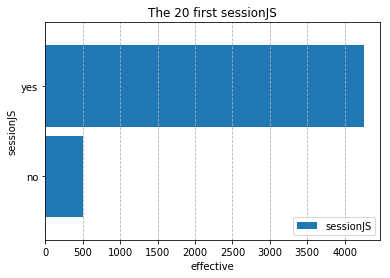

There are 0 unique terms for the attribute 'sessionJS'

The most used terms are: 
yes    4262
no      498
Name: sessionJS, dtype: int64


In [145]:
terms_analysis(df_consistent, 'sessionJS')

The distinct values for the attribute 'languageHttp' are : 
 ['de' 'pt' 'ru' 'en' 'fr' 'cs' 'da' 'it' 'nl' 'sv' 'sl' 'es' 'nb' 'hu'
 'pl' 'sh' 'ja' 'ac' 'uk' 'zh' 'tr' 'az' 'sk' 'fi' 'ko' 'th' 'vi' 'hr'
 'ro' 'an' 'ch' 'ca' 'ar' 'lt' 'el' 'af' 'bg' 'et']

    effective          %
en       2672  53.968895
ru        850  17.168249
fr        583  11.775399
de        320   6.463341
es         79   1.595637
it         61   1.232074
pl         59   1.191678
zh         57   1.151283
nl         52   1.050293
pt         42   0.848313
hu         35   0.706928
cs         21   0.424157
ja         18   0.363563
uk         13   0.262573
da         12   0.242375
tr          8   0.161584
ac          8   0.161584
sv          8   0.161584
fi          6   0.121188
vi          6   0.121188
ko          5   0.100990
sk          5   0.100990
af          4   0.080792
hr          4   0.080792
lt          3   0.060594
sl          3   0.060594
el          2   0.040396
nb          2   0.040396
sh          2   0.0

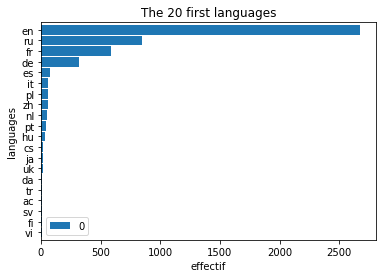

There are 7 unique terms for the attribute 'languageHttp'

The most used terms are: 
en    2672
ru     850
fr     583
de     320
es      79
Name: 0, dtype: int64


In [10]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []

# takes the first two characters
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']

print()
print(tab)
print()

df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages')
plt.xlabel('effective')
plt.ylabel('languages')
plt.show()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [8]:
def analysis_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

def split_encoding_http(encoding):
    return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

                                                    effective          %
Chrome PDF Viewer                                        8912  14.564947
Shockwave Flash                                          8474  13.849121
Widevine Content Decryption Module                       4792   7.831601
Native Client                                            4679   7.646924
Microsoft Office                                         3228   5.275544
Adobe Acrobat                                            2889   4.721514
Google Update                                            2278   3.722952
Silverlight Plug-In                                      1862   3.043080
QuickTime Plug-in                                        1695   2.770151
JavaTM Platform SE                                       1657   2.708047
Java Deployment Toolkit                                  1591   2.600183
Intel                                                    1398   2.284762
VLC Web Plugin                                     

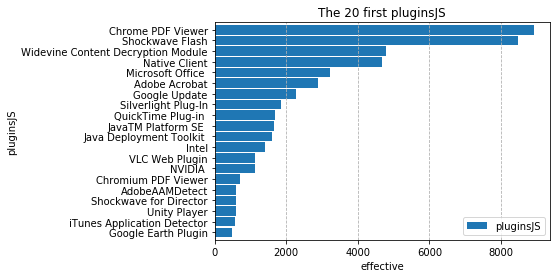

There are 106 unique terms for the attribute 'pluginsJS'

The most used terms are: 
Chrome PDF Viewer                     8912
Shockwave Flash                       8474
Widevine Content Decryption Module    4792
Native Client                         4679
Microsoft Office                      3228
Name: pluginsJS, dtype: int64

There are 460 pluginsJS


In [255]:
analysis_terms_splited(df_consistent, 'pluginsJS', split_plugins)

In [10]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [38]:
analyze_grouped(df_consistent,'localJS', 'sessionJS')

KeyError: 'sessionJS'

In [11]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    #print(stats_grouped)
    #stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]

In [23]:
analyze_grouped_splited(df_consistent, 'encodingHttp', 'browserFamily', split_encoding_http)


browserFamily
Firefox    3
dtype: int64
11703118
br
browserFamily
Chrome            1597
Chromium            43
Dragon               3
Epiphany             1
Firefox           1912
IE Mobile            1
Iceweasel            3
Iron                28
Konqueror            1
Opera                8
Other                5
QupZilla             1
Rekonq               1
SeaMonkey            1
Vivaldi             38
Yandex Browser       4
dtype: int64
876300
bzip2
browserFamily
Chrome    1
dtype: int64
11713896
compress
browserFamily
Chrome    1
dtype: int64
11713896
deflate
browserFamily
Chrome                         2274
Chromium                         72
Dragon                            9
Epiphany                          2
Firefox                        2553
IE Mobile                         1
Iceweasel                        32
Iron                             37
Konqueror                         1
Maxthon                           1
Opera                            15
Other           

In [165]:
analyze_grouped_splited(df_consistent, 'vendorWebGLJS', ['os', 'browserFamily'], split_plugins)

os             browserFamily              
Chrome OS      Chrome                          72
FreeBSD        Chrome                           1
               Firefox                          3
Linux          Chrome                         304
               Firefox                        177
               Iceweasel                       32
               Iron                             6
               Konqueror                        1
               Opera                            1
               QupZilla                         1
               Rekonq                           1
               Vivaldi                         14
Mac OS X       Chrome                         390
               Firefox                        191
               Iron                             1
               Opera                            2
               SeaMonkey                        1
               Vivaldi                          6
NetBSD         Firefox                          1
OpenBSD

KeyError: 'vendorWebGLJS'

## Inconsistent fingerprint detection

In [139]:
dict_null=[]
for attribute in attributes_to_analyze:
    nb_values_null = len(df_consistent[df_consistent[attribute].isnull()])
    dict_null.append({
        "attribute":attribute,
        "number of values null":nb_values_null
    })
df_dict_null = pd.DataFrame(dict_null)
df_dict_null

attribute  number of values null
0                     id                      0
1            addressHttp                      0
2          userAgentHttp                      7
3             acceptHttp                      0
4         connectionHttp                      0
5           encodingHttp                      2
6           languageHttp                     15
7              orderHttp                      0
8        pluginsJSHashed                      0
9             platformJS                      1
10             cookiesJS                      0
11                 dntJS                      0
12            timezoneJS                      0
13          resolutionJS                      0
14               localJS                      0
15             sessionJS                      0
16        canvasJSHashed                      0
17      fontsFlashHashed                      0
18       resolutionFlash                      0
19         languageFlash                      0
20         platformFlash                      0
21         browserFamily                      0
22  globalBrowserVersion                      0
23   minorBrowserVersion                      0
24   majorBrowserVersion                      0
25                    os                      0
26       rendererWebGLJS                      0
27         vendorWebGLJS                      0
28             pluginsJS                   1905

In [142]:
# Détection of inconsistent values
df_consistent[df_consistent['platformJS'].isnull()]

counter                                    id        creationDate  \
38502    49117  bb2d1703-0c56-49cd-bf02-4af5d1bceb30 2016-06-30 12:00:00   

      endDate                               addressHttp  \
38502    None  5aff60bc3b6c8c04f3c5934e10a9cfff857751a2   

                                           userAgentHttp  \
38502  Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.3...   

                                              acceptHttp connectionHttp  \
38502  text/html,application/xhtml+xml,application/xm...          close   

        encodingHttp    languageHttp    ...     platformFlash browserFamily  \
38502  gzip, deflate  en-GB,en;q=0.5    ...         Windows 7        Chrome   

      globalBrowserVersion minorBrowserVersion majorBrowserVersion  \
38502                  450                   0                  45   

                  os rendererWebGLJS  vendorWebGLJS  \
38502  Windows Vista   Not supported  Not supported   

                                               pluginsJS consistent  
38502  Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For...       True  

[1 rows x 33 columns]

In [119]:
# Id of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['id'] == "d2356d2d-9796-4522-949e-616aa1521059"]

counter                                    id        creationDate  \
71595    93843  d2356d2d-9796-4522-949e-616aa1521059 2016-12-04 01:00:00   

      endDate                               addressHttp userAgentHttp  \
71595    None  8f60d3ad84d108cabb80a4e40a488878396c0448           NaN   

                                              acceptHttp connectionHttp  \
71595  text/html,application/xhtml+xml,application/xm...          close   

            encodingHttp    languageHttp    ...           platformFlash  \
71595  gzip, deflate, br  en-US,en;q=0.5    ...      Flash not detected   

      browserFamily globalBrowserVersion minorBrowserVersion  \
71595         Other               zzzzzz                None   

      majorBrowserVersion     os rendererWebGLJS  vendorWebGLJS pluginsJS  \
71595                None  Other   Not supported  Not supported       NaN   

      consistent  
71595       True  

[1 rows x 33 columns]

In [109]:
df_consistent['browserFamily'].value_counts()

Chrome                         28157
Firefox                        19183
Chromium                         425
Iron                             353
Vivaldi                          220
Iceweasel                        141
Opera                             71
Dragon                            37
Yandex Browser                    21
Other                             11
IE Mobile                          3
Epiphany                           2
Pale Moon (Firefox Variant)        2
Maxthon                            1
Rekonq                             1
QupZilla                           1
SeaMonkey                          1
Konqueror                          1
Name: browserFamily, dtype: int64

In [165]:
df_consistent[df_consistent['encodingHttp'] == "gzip, deflate, , br"]["id"]

82110    b6c38cfd-7fc0-4591-b908-bcd7769ab2b5
Name: id, dtype: object

## Temporal analysis of consistent fingerprints

In [91]:
#id with more 2 fingerprints
number_fingerprints_by_id=df_consistent['id'].value_counts()
df_number_fingerprints_by_id=pd.DataFrame(number_fingerprints_by_id)
user_more_2_fingerprints=[]
for user_id, number in df_number_fingerprints_by_id.iteritems():
    for i in range(0, len(number)):
        if number[i] != 1:
            user_more_2_fingerprints.append({
                "valeur":number[i],
                "index":number.index[i]
            })
            
df_user_more_2_fingerprints=pd.DataFrame(user_more_2_fingerprints)

### Frequency of attributes changes

In [164]:
#frequency of changes of each attribute in time (days)
List_frequency_attributes=[]
attribute_to_times = dict()

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        first_value_date = df_filtered_id.iloc[0]['creationDate']
        first_value = df_filtered_id.iloc[0][attribute]
        
        #if there are no changes
        if attribute not in attribute_to_times:
            attribute_to_times[attribute] = []
        
        last_change = False
        
        #count the number of days between each changes in the attribute then store it in a dict
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
#                 print(row[attribute])
#                 print(first_value)
#                 print()
                date_next=row['creationDate']
                attribute_to_times[attribute].append((date_next-first_value_date).days)
                first_value_date=row['creationDate']
                first_value=row[attribute]
            
                #if there is a change in the n-1 value then we say that there is a last change
                if index == len(df_filtered_id) -1:
                    last_change = True
            

        #Otherwise, we add to the list the NaN value    
        if not last_change:
            attribute_to_times[attribute].append(np.nan)
          
            
            
dict_stat=[]
for attribute in attribute_to_times:
    #try:
        # sort in descending order
    arr = np.sort(attribute_to_times[attribute])[::-1]

    #creation of quantiles
    Q95 = arr[int(0.95*len(arr))]
    Q90 = arr[int(0.90*len(arr))]
    median = arr[int(0.50*len(arr))]
    dict_stat.append({
        "attribute":attribute,
        "Q90":Q90,
        "median":median,
        "Q95":Q95
    })
    #except IndexError:
#        pass

#create a dataframe for the visualization
df_stat = pd.DataFrame(dict_stat)

#put in index the name of attributes
df_stat = df_stat.set_index("attribute")

#replace NaN by 'Never'
for column in df_stat:
    df_stat[column].replace(to_replace=[NaN], value='Never', inplace=True) 

df_stat_order = df_stat[['median','Q90','Q95']]
df_stat_order

median    Q90    Q95
attribute                                
id                    Never  Never  Never
addressHttp               2      0      0
userAgentHttp            23      0      0
acceptHttp            Never  Never  Never
connectionHttp        Never  Never  Never
encodingHttp          Never     11      0
languageHttp          Never      5      0
orderHttp             Never      0      0
pluginsJSHashed          28      0      0
platformJS            Never  Never  Never
cookiesJS             Never  Never  Never
dntJS                 Never      3      0
timezoneJS            Never      0      0
resolutionJS              1      0      0
localJS               Never  Never      2
sessionJS             Never  Never     16
canvasJSHashed        Never      0      0
fontsFlashHashed          2      0      0
resolutionFlash           1      0      0
languageFlash             5      0      0
platformFlash             6      0      0
browserFamily         Never  Never  Never
globalBrowserVersion     59      8      1
minorBrowserVersion   Never  Never  Never
majorBrowserVersion      60      8      1
os                    Never  Never  Never
rendererWebGLJS       Never      0      0
vendorWebGLJS         Never      9      0
pluginsJS                20      0      0

### Does everyone change so often ?

In [22]:
list_all=[]
list_freq=[]
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    # delete columns not to be analyzed (0 for line ans 1 for column)
#     df_filtered_counter = df_filtered_id.drop('counter', 1)
#     df_filtered_endDate = df_filtered_counter.drop('endDate', 1)
#     df_filtered_consistent = df_filtered_endDate.drop('consistent', 1)
#     df_filtered_date = df_filtered_consistent.drop('creationDate', 1)
    
    df_filtered_date = df_filtered_id.drop('counter', 1).drop('endDate', 1).drop('consistent', 1).drop('creationDate', 1)

    liste_time = []

    first_line = df_filtered_date.iloc[0]
    list_first_line = list(first_line)

    first_value_date = df_filtered_id.iloc[0]['creationDate']
    last_value_date = df_filtered_id.iloc[-1]['creationDate']

    # for each line of group of fingerprints of the user
    for line in range(1, len(df_filtered_date)):
        line_entire=df_filtered_date.iloc[line]
        list_line_entire = list(line_entire)
        
        # if line next is defferent to previous line then storage of number of days between the two lines
        if list_line_entire != list_first_line:
            date_line = df_filtered_id.iloc[line]['creationDate']
            liste_time.append((date_line-first_value_date).days)
            first_value_date = df_filtered_id.iloc[line]['creationDate']
            first_line = line_entire
        # else the first line becomes the next
        else:
            first_line = line_entire
    
    # storage of all values in a single list for cumulative distribution for all fingerprints
#     list_all.append(np.nanmean(liste_time))
    # average of each list of values for each user
#     mean_liste=np.nanmean(liste_time)
    list_freq.append({
        'user':user_id,
        'mean':np.nanmean(liste_time)
    })

# for the visualization : creation a dataframe
df_list_freq=pd.DataFrame(list_freq)
df_list_freq

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


mean                                  user
0      0.101572  c3af36ba-81f4-4652-9523-44f2217dc0f0
1      0.290965  2bef0281-b2d9-41ac-967c-45835e5ba8c0
2      0.294393  efca79c2-0b12-4ce7-a28f-68ad9193990d
3      0.000000  77aae6f6-0bbd-4138-baa4-142c1e4dddcd
4      0.801402  f61809d2-a428-4a2c-81e4-461ea9908687
5      0.904878  d4be492d-c9ee-46a0-b1ab-076386b61b85
6      0.780488  68942969-0475-4a26-931b-d1d8043a659c
7      0.801090  31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8
8      1.395498  c17f5405-360e-43d7-9b50-bccf6faf2207
9      0.842697  b8f4eb79-baaf-442b-ada2-5bcd5cf89df4
10     0.621723  ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1
11     1.465909  f4f25187-82c7-4265-9bf9-71bc8ed1701f
12     1.053232  907af844-581a-4044-8ddb-8bcc91df32f9
13     1.506024  d7969eaf-cd67-4ac5-b060-393d864f8525
14     1.446721  c28aa37d-571e-4b43-bf01-aa14eeb765e7
15     0.853448  2f38656b-76d5-4b46-a81d-c90b96495673
16     0.701299  7a26546e-0a07-423c-9e97-0ef56212920d
17     0.405286  893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62
18     0.614350  39107c52-98c9-4a75-b505-271294fac465
19     1.761658  628a06f1-ca1e-4e6e-9b38-5e23da554b53
20     0.941520  a5f01fef-bcda-49d6-b726-2fe0d7a4e928
21     2.593750  f258256f-54bc-46fc-baca-9df34d5ff3ac
22     1.569620  3f18eefa-8d4c-4381-b642-f2feca50f63a
23     0.676259  595525a1-8ff1-493d-bdef-74ecb74d182b
24     1.254902  8b10f12f-516a-44ee-9e79-134d040d1ef4
25     0.879195  2c383b80-2256-4ece-81d4-c81290a10a14
26     0.879195  1603f573-55cc-47f7-93a2-29ea605789ce
27     2.931973  2657b615-04b0-4c11-8343-1245c9c07676
28     1.309859  718eaf95-e9e2-42a2-ba4c-5316b5f45fdf
29     1.014493  ece552c2-b04a-49f3-a01f-244ea2be828f
...         ...                                   ...
2490  60.000000  629824ed-7093-4efa-9c7e-b607ba013437
2491   0.000000  f2e985a7-a490-4496-afc0-0c7a2e9efc10
2492  45.000000  bf539262-4821-49f7-974a-29079e05cb54
2493   0.000000  53d8b227-71e4-4b4c-a2ff-1efe0b587986
2494  11.000000  050dcb4c-f87d-4790-88e9-7411bae11341
2495  23.000000  bb1ba111-0f76-4ff3-a84e-331223116f1d
2496   1.000000  4e7d1edc-ae76-47b9-9177-e090b30bc0a3
2497   9.000000  5ee240dd-61ae-4dee-9360-64977c61be4b
2498   0.000000  130d3e49-4369-4c45-b5f4-7990c4bf5ce3
2499   1.000000  984cab23-93e0-4047-beba-06e1b891687d
2500   0.000000  78cdfd5e-66aa-4752-8cb3-392b32ed94b7
2501   0.000000  24eb4d59-3381-4877-86dd-f9baa93cf4a8
2502   2.000000  a530fb43-5163-4528-b65b-c338698eee79
2503   3.000000  66c96b21-96eb-4ceb-8f79-ca805bf5f6e9
2504  49.000000  ffe8a4f4-6cc3-4c0c-8ce7-9dc1b36e03a1
2505   0.000000  a50fd23b-d043-443c-a866-468061c915a0
2506   1.000000  41cbc163-2407-460a-a9cc-761d88bb2af7
2507   1.000000  9088d7fc-9ac2-42e2-9486-65a3fbdfe05a
2508  16.000000  65899634-2fea-4e9c-a949-c9d7f9b18ba9
2509   1.000000  8b5991aa-dadd-4a50-9ffa-a422bf9c9294
2510  34.000000  75c78e5d-7291-4f48-bf45-4c51d678f58e
2511   2.000000  7b2cbf31-9bad-4014-b51d-19799a459759
2512   0.000000  7b304520-1343-44ae-962e-bbc316739507
2513   0.000000  d55d67b1-c871-4bd1-b642-ed5cb5192b94
2514  66.000000  fcd8e5e0-d206-4145-b18b-314457ad5290
2515   0.000000  a6da4ebe-e837-4ad7-83f0-4ef7d447e88d
2516   1.000000  157f5a22-4d17-4fec-b820-18c95dba2a56
2517   0.000000  d3997ae4-fd1e-432b-85e8-0d937e51794e
2518   0.000000  0758c899-b257-4fb1-8db9-e85a94bd578a
2519  36.000000  f00cf792-29e9-40be-ac75-9a79c4dd86ea

[2520 rows x 2 columns]

In [8]:
# graph
# max_abs is the value for the maximum of the abscissa axe and probability = [0.0:1.0]

def CDF_evolution(max_abs, probability):  
    
    # sort 
    x_fig_average = np.sort(df_list_freq['mean'])
    x_fig_all = np.sort(list_all)

    # length
    N_fig_average = len(x_fig_average)
    N_fig_all = len(x_fig_all)

    #creation of the y-axis for a cumulative distribution function
    y_fig_average = np.array(range(N_fig_average))/float(N_fig_average)
    y_fig_all = np.array(range(N_fig_all))/float(N_fig_all)

    # dimension of the figure
    fig = plt.figure(figsize=(15,9))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_fig_all, y_fig_all, label = 'Over all fingerprints')
    ax.plot(x_fig_average, y_fig_average, label = 'Average per user')
    
    # horizontal line for the percentile
    ax.plot([0.0, 50],[probability,probability], 'g--', lw=2)

    # legend in better place
    ax.legend(loc='best', prop={'size': 12})

    # interval of the abscissa axis and y-axis 
    ax.set_xlim(-0.05, max_abs)
    ax.set_ylim(0,1)
    
    ax.set_title("Cumulative distribution function of the elapsed time before a fingerprint evolution \nover all fingerprints and averaged per user\n")
    ax.set_xlabel("Days before a change occurs in a fingerprint", size = 12)
    ax.set_ylabel("P(X)", size = 12)
    
    # graduation of abscissa axis with a one step
    ax.xaxis.set_major_locator(MultipleLocator(1))


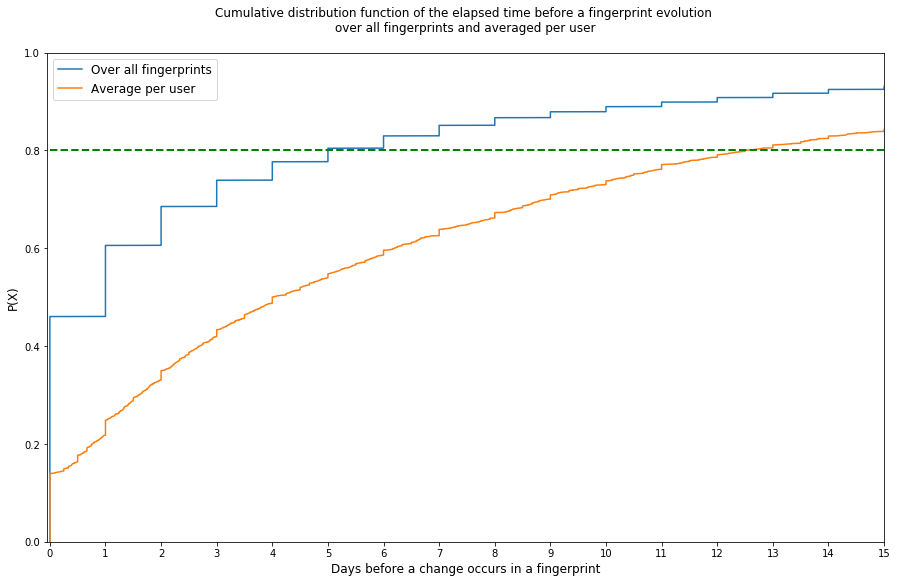

In [181]:
CDF_evolution(15,0.8)

### Attributes that change at the same time

In [24]:
df_consistent['creationDate'].iloc[-1] - df_consistent['creationDate'].iloc[0]

Timedelta('594 days 14:00:00')

In [152]:
# initialization of a dictionnary
attribute_changes = dict()

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        #first_value_date = df_filtered_id.iloc[0]['creationDate']
        first_value = df_filtered_id.iloc[0][attribute]
        
        #if there are no changes
        if attribute not in attribute_changes:
            attribute_changes[attribute] = []

        
        #count the number of days between each changes in the attribute then store it in a dict
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
                #date_next=row['creationDate']
                #attribute_changes[attribute].append((date_next-first_value_date).days)
                attribute_changes[attribute].append(1)
                #first_value_date=row['creationDate']
                first_value=row[attribute]

            else:
                #attribute_changes[attribute].append(650)
                attribute_changes[attribute].append(0)

df_attribute_changes = pd.DataFrame(attribute_changes)


In [17]:
# The deletion of attributes is done in sup_attributes, not in attributes_to_analyze
sup_attributes = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]

# creation an empty dataframe
df_correlation=pd.DataFrame()

for attribute_to_compare in attributes_to_analyze:
    correlation=[]
    remaining_attributes = sup_attributes
    
    for attribute in remaining_attributes: 
        
        # Initialization of variables
        first_value_attribute = df_attribute_changes.iloc[0][attribute]
        first_value_attribute_to_compare = df_attribute_changes.iloc[0][attribute_to_compare]

        # calculation of the correlation between the variable to compare and each remaining variable 
        correlation.append(df_attribute_changes[attribute].corr(df_attribute_changes[attribute_to_compare], method='pearson'))
    
    # Deleting of attribute that we have just compared in the remaining list
    remaining_attributes = remaining_attributes.remove(attribute_to_compare)
    
    # adding white in columns to merge all columns together
    while len(correlation) != len(attributes_to_analyze):
        a=" "
        correlation = [a]+correlation
    
    # adding the created column in dataframe
    df_correlation[attribute_to_compare] = correlation
 
 # adding a column to index the attributes
df_correlation["attribute"]=attributes_to_analyze
df_correlation= df_correlation.set_index("attribute")

# delete columns and rows with missing data for an attribute because it does not change over time 
# thresh is an optional that requires a given number of non-missing values
df_correlation = df_correlation.dropna(axis=1,thresh=26)
df_correlation = df_correlation.dropna(axis=0,thresh=24)
df_correlation = df_correlation.drop(['id'])
df_correlation

addressHttp userAgentHttp   acceptHttp encodingHttp  \
attribute                                                                  
addressHttp                    1                                           
userAgentHttp         -0.0854949             1                             
acceptHttp             0.0163983     0.0370858            1                
encodingHttp          -0.0128005       0.10387     0.142806            1   
languageHttp          -0.0264431     0.0582013     0.169873    0.0469862   
orderHttp              -0.034465      0.100459  -0.00482548     0.099236   
pluginsJSHashed       -0.0932849      0.162132    0.0393349    0.0253334   
platformJS           -0.00634697     0.0994373     0.101664    0.0582547   
cookiesJS             -0.0153838   -0.00959464    0.0246977  -0.00440124   
dntJS                  -0.024443    0.00701085  -0.00240012    0.0155222   
timezoneJS             0.0738984    -0.0406144  -0.00518282  -0.00680511   
resolutionJS          0.00885295     -0.203481    -0.015264   -0.0623593   
localJS               -0.0290865   -0.00564316  -0.00168745   0.00606647   
sessionJS              -0.016616    0.00272409  -0.00146037   0.00954468   
canvasJSHashed        -0.0225914      0.157819  -0.00537949    0.0405496   
fontsFlashHashed        0.016177    -0.0743369   -0.0170546   -0.0364405   
resolutionFlash         0.146958     -0.132345   -0.0179064   -0.0524856   
languageFlash            0.15396   -0.00906974   -0.0113966   -0.0174881   
platformFlash           0.146413     0.0154163   -0.0116698   -0.0145385   
globalBrowserVersion  -0.0573382       0.69641  -0.00337247      0.14702   
minorBrowserVersion   -0.0053174     0.0713811 -0.000697986   0.00829391   
majorBrowserVersion   -0.0567528      0.693247  -0.00332844     0.147878   
rendererWebGLJS       0.00143395     0.0508039  -0.00315173    0.0091108   
vendorWebGLJS         -0.0298744     0.0709549  -0.00240718    0.0154048   
pluginsJS             -0.0811215      0.148035    0.0399562    0.0250698   

                     languageHttp    orderHttp pluginsJSHashed   platformJS  \
attribute                                                                     
addressHttp                                                                   
userAgentHttp                                                                 
acceptHttp                                                                    
encodingHttp                                                                  
languageHttp                    1                                             
orderHttp               0.0725599            1                                
pluginsJSHashed        0.00149926     0.030337               1                
platformJS              0.0458436    0.0520749       0.0942608            1   
cookiesJS               0.0117221    0.0348597     -0.00854157    0.0108735   
dntJS                   0.0761769     0.482243       0.0124684    0.0397029   
timezoneJS            -0.00553197  0.000599006      -0.0142384  -0.00409047   
resolutionJS           -0.0654016   -0.0772706       -0.184832    -0.029013   
localJS                 0.0261385    0.0513034      -0.0138024   0.00287552   
sessionJS               0.0325435    0.0555196     -0.00811858   0.00430755   
canvasJSHashed          0.0416715    0.0615874        0.079864    0.0326932   
fontsFlashHashed       -0.0484301   -0.0289141       0.0245981   -0.0133121   
resolutionFlash        -0.0546418   -0.0419834      -0.0127467   -0.0172255   
languageFlash          -0.0186967    0.0159549        0.137011  8.47841e-05   
platformFlash          -0.0186243     0.014809        0.135933 -0.000793312   
globalBrowserVersion    0.0867868     0.111119        0.217653    0.0793142   
minorBrowserVersion     0.0220544    0.0106445     -0.00259179     0.013756   
majorBrowserVersion     0.0873959     0.110921        0.218836    0.0797321   
rendererWebGLJS         0.0807873    0.0123333       0.0467367   0.00728

In [18]:
# part of the missing table
df_correlation[df.columns[15 :21]]

timezoneJS resolutionJS     localJS    sessionJS  \
attribute                                                                
addressHttp                                                              
userAgentHttp                                                            
acceptHttp                                                               
encodingHttp                                                             
languageHttp                                                             
orderHttp                                                                
pluginsJSHashed                                                          
platformJS                                                               
cookiesJS                                                                
dntJS                                                                    
timezoneJS                     1                                         
resolutionJS          -0.0992368            1                            
localJS              -0.00626447    -0.044333           1                
sessionJS            -0.00233335   -0.0374626    0.815572            1   
canvasJSHashed         0.0296689    0.0247602 -0.00208378   0.00267653   
fontsFlashHashed      -0.0874641    -0.317258  -0.0419329   -0.0336736   
resolutionFlash       -0.0999202     0.361386  -0.0442973   -0.0348909   
languageFlash         -0.0322093    -0.201458  -0.0221071   -0.0155808   
platformFlash         -0.0326949    -0.206766  -0.0232128    -0.017411   
globalBrowserVersion  -0.0102514    -0.132452   0.0114661    0.0196627   
minorBrowserVersion  -0.00701907   -0.0176538 -0.00228531  -0.00197777   
majorBrowserVersion  -0.00971855    -0.131611    0.011696    0.0198988   
rendererWebGLJS        0.0866806     0.065928 -0.00179229  0.000908726   
vendorWebGLJS         -0.0053398     0.017565  0.00319495   0.00596028   
pluginsJS              0.0041081    -0.173085  0.00868392    0.0188644   

                     canvasJSHashed fontsFlashHashed  
attribute                                             
addressHttp                                           
userAgentHttp                                         
acceptHttp                                            
encodingHttp                                          
languageHttp                                          
orderHttp                                             
pluginsJSHashed                                       
platformJS                                            
cookiesJS                                             
dntJS                                                 
timezoneJS                                            
resolutionJS                                          
localJS                                               
sessionJS                                             
canvasJSHashed                    1                   
fontsFlashHashed         -0.0311948                1  
resolutionFlash          -0.0121982          0.33887  
languageFlash            -0.0154078         0.666124  
platformFlash           -0.00463933         0.656345  
globalBrowserVersion       0.232393       -0.0447389  
minorBrowserVersion      0.00828672       -0.0158215  
majorBrowserVersion        0.233174       -0.0438425  
rendererWebGLJS            0.182024      -0.00158375  
vendorWebGLJS              0.123588      -0.00335541  
pluginsJS                 0.0835559       -0.0324151

In [76]:
# save of the table for a complete visualization
df_correlation.to_csv('/home/spirals/Documents/attributes_change_corre.csv', index=True)

In [63]:
# other method to have the table

S = np.diag(1/df_attribute_changes.iloc[:,0:30].std())
mu = np.matrix(df_attribute_changes.iloc[:,0:30].mean())
U = np.matrix([np.ones(df_attribute_changes.iloc[:,0:30].shape[0])])
X = pd.DataFrame((df_attribute_changes.iloc[:,0:30] - U.T.dot(mu)).dot(S).values,columns = df_attribute_changes.columns[0:30])

Var_X = X.cov()
# delete column with nan
Var_X = Var_X.dropna(axis=1,thresh=1)
Var_X = Var_X.dropna(axis=0,thresh=1)
Var_X

### Number of plugins in time

In [8]:
print("The following analysis is done from {} to {}".format(min(df_consistent['creationDate']),max(df_consistent['creationDate'])))

The following analysis is done from 2015-07-27 11:00:00 to 2017-03-13 01:00:00


In [141]:
evolution=[]

# for each user, storage of the date
for user_id in df_user_more_2_fingerprints['index']:
    date=df_consistent[df_consistent['id']==user_id]['creationDate']  
    df_date = pd.DataFrame(date)
    df_date = df_date['creationDate'].apply(lambda x: x.strftime('%B-%Y'))
    year_month=[]
    for key, line in df_date.iteritems():
        year_month.append({
            "cle": key,
            "Date":line
        })

    df_year_month = pd.DataFrame(year_month)
    
    plugins = df_consistent[df_consistent['id']==user_id]['pluginsJS']
    df_plugins = pd.DataFrame(plugins)
    nb_plugins = df_plugins['pluginsJS']
    liste=[]
    for key, line in nb_plugins.iteritems():
        liste.append({
            "cle": key,
            "number of plugins":len(str(line).split(":"))-1
        })
          
    df_liste = pd.DataFrame(liste)
    annee_mois_nb_plugins = df_year_month.join(df_liste['number of plugins'])
    
    # get the last: -1 for the lest line and 2 for the column 'number of plugins'
    nb_fin=annee_mois_nb_plugins.iloc[-1,2]
    nb_debut=annee_mois_nb_plugins.iloc[0,2]
    nb_final=nb_fin-nb_debut

    list_final = []
    list_final.append(nb_final)
    df_list_final = pd.DataFrame(list_final)
    evolution.append(nb_final)
    
count_inf=0
count_sup=0
count_zero=0
for i in range(0,len(evolution)):
    if evolution[i]<0:
        count_inf=count_inf+1
    elif evolution[i]>0:
        count_sup=count_sup+1
    else:
        count_zero=count_zero+1
print("The number of plugins decreases for {:d} id".format(count_inf))
print("The number of plugins increases for {:d} id".format(count_sup))
print("The number of plugins stagnates for {:d} id".format(count_zero))

The number of plugins decreases for 677 id
The number of plugins increases for 298 id
The number of plugins stagnates for 1545 id
Conclusion: over time, the number of plugins tends to stagnate


/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


Text(0,0.5,'Number of plugins on average')

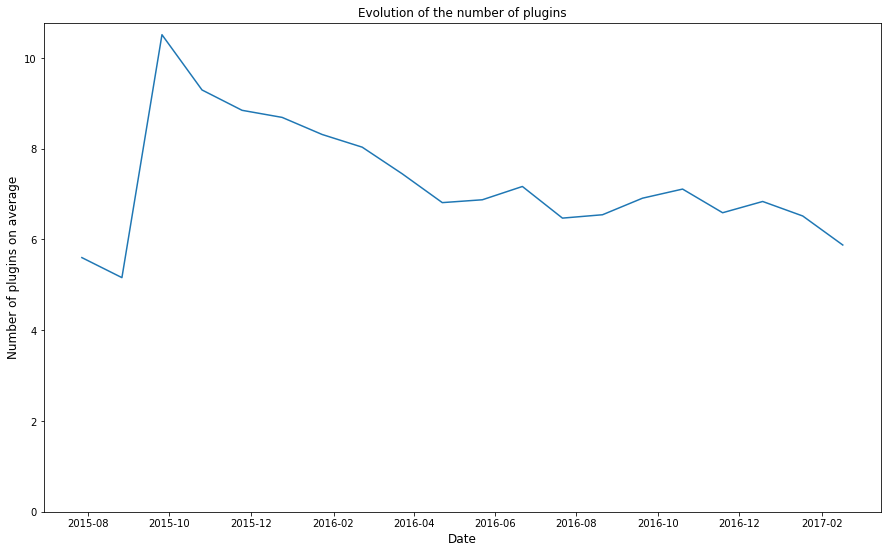

In [24]:
plugins_changes=[]

for user_id in df_user_more_2_fingerprints['index']:
    
    # sort the dataframe by date of creation
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    for line in range(0,len(df_filtered_id)):
        plugins_changes.append({
            "date":df_filtered_id.iloc[line]['creationDate'],
            "plug": len(str(df_filtered_id["pluginsJS"].iloc[line]).split(":"))-1
        })            

# sort of dataframe by date
df_plugins_changes = pd.DataFrame(plugins_changes)
sorting_df_plugins_changes=df_plugins_changes.sort_values("date")

# enlarge the chart
fig = plt.figure(figsize=(15,9))

graph_plugins_changes = fig.add_subplot(1, 1, 1)

# groups the number of plugins by date and makes an average
average_plugins_by_xday=sorting_df_plugins_changes.set_index('date').groupby(pd.TimeGrouper('30D')).mean()

graph_plugins_changes.plot(average_plugins_by_xday)

# interval of the y-axis 
graph_plugins_changes.set_ylim(ymin=0)

graph_plugins_changes.set_title("Evolution of the number of plugins")
graph_plugins_changes.set_xlabel("Date", size = 12)
graph_plugins_changes.set_ylabel("Number of plugins on average", size = 12)


### Evolution of number of language in time

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


Text(0,0.5,'Number of languages on average')

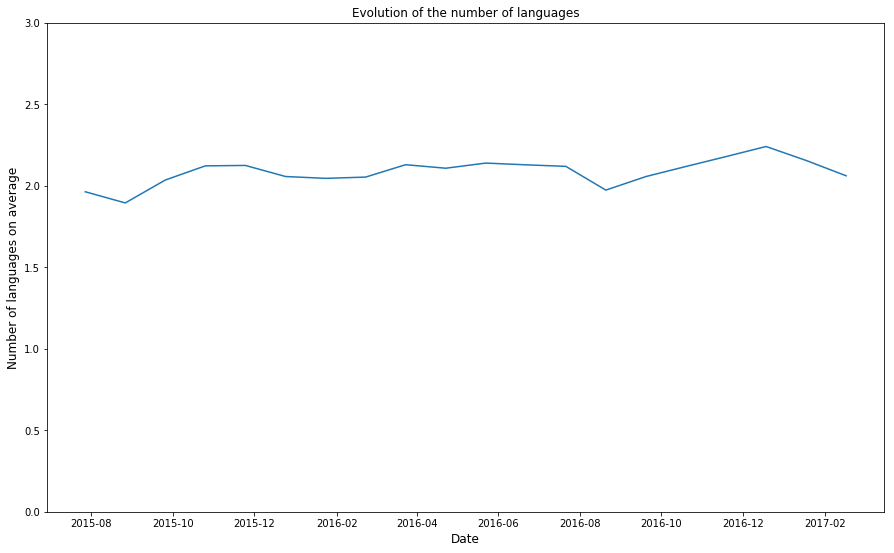

In [81]:
nb_languages=[]
for user_id in df_user_more_2_fingerprints['index']:
    
    # sort the dataframe by date of creation
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')
    for value in range(0,len(df_filtered_id['languageHttp'])):
        nb_languages.append({
            "date":df_filtered_id.iloc[value]['creationDate'],
            "number_languages": len((df_filtered_id['languageHttp'].iloc[value].split(",")))-1
        })
        
# sort of dataframe by date
df_nb_languages = pd.DataFrame(nb_languages)
sorting_df_nb_languages=df_nb_languages.sort_values("date")
            
# enlarge the chart
fig = plt.figure(figsize=(15,9))

graph_nb_languages = fig.add_subplot(1, 1, 1)

# groups the number of languages by date and makes an average
average_languages_by_xday=sorting_df_nb_languages.set_index('date').groupby(pd.TimeGrouper('30D')).mean()

graph_nb_languages.plot(average_languages_by_xday)

# interval of the y-axis 
graph_nb_languages.set_ylim(0,3)

graph_nb_languages.set_title("Evolution of the number of languages")
graph_nb_languages.set_xlabel("Date", size = 12)
graph_nb_languages.set_ylabel("Number of languages on average", size = 12)

### Evolution of priority of languages over time

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


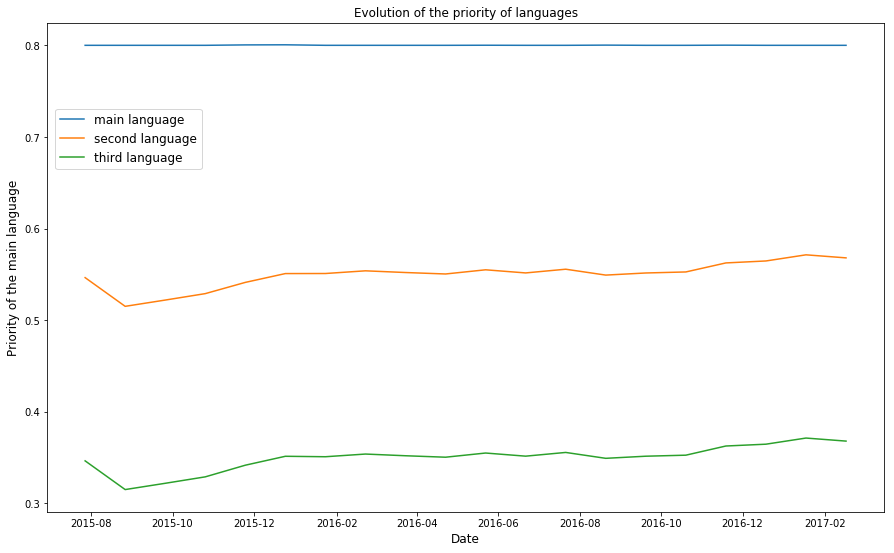

In [151]:
priority_languages=[]
for user_id in df_user_more_2_fingerprints['index']:
    
    # sort the dataframe by date of creation
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')
    for value in range(0,len(df_filtered_id['languageHttp'])):
        list_languages = df_filtered_id['languageHttp'].iloc[value].split(",")
        df_list_languages = pd.DataFrame(list_languages)
        
        # for splitter when there is no "="
        try:
            # 1 to take the first priority, 2 for the second and 3 for the third
            select_number_first_priority = df_list_languages[0].str.split("=")[1]
            select_number_second_priority = df_list_languages[0].str.split("=")[2]
            select_number_third_priority = df_list_languages[0].str.split("=")[3]
            priority_languages.append({
                "date":df_filtered_id.iloc[value]['creationDate'],
                "main language": float(select_number_first_priority[1]),
                "second language": float(select_number_second_priority[1]),
                "third language": float(select_number_third_priority[1])
            })
        except:
            # otherwise it goes to the next line
            value = value+1

        
# sort of dataframe by date for the plot
df_priority_languages = pd.DataFrame(priority_languages)
sorting_df_priority_languages=df_priority_languages.sort_values("date")
            
# enlarge the chart
fig = plt.figure(figsize=(15,9))

graph_priority_languages = fig.add_subplot(1, 1, 1)

# groups the priority by date and makes an average
average_priority_by_xday=sorting_df_priority_languages.set_index('date').groupby(pd.TimeGrouper('30D')).mean()

# drawing of the 3 curves and for the legend
graph_priority_languages.plot(average_priority_by_xday["main language"])
graph_priority_languages.plot(average_priority_by_xday["second language"])
graph_priority_languages.plot(average_priority_by_xday["third language"])

graph_priority_languages.set_title("Evolution of the priority of languages")
graph_priority_languages.set_xlabel("Date", size = 12)
graph_priority_languages.set_ylabel("Priority of the main language", size = 12)

# position of legend
graph_priority_languages.legend(loc=[0.01,0.7], prop={'size': 12})


### At a given moment, for the same browser, do the majority of people have the same version?

In [165]:
study_version=[]

for i in range(0, len(df_consistent["browserFamily"])):
    if df_consistent["browserFamily"].iloc[i]=="Chrome":
        study_version.append({
            "user":df_consistent["id"].iloc[i],
            "date":df_consistent["creationDate"].iloc[i],
            "version":df_consistent["globalBrowserVersion"].iloc[i]
        })

df_study_version = pd.DataFrame(study_version)

d1 = (3, 28)
d2 = (3, 31)
d3 = (4, 2)

for line in df_study_version.iterrows():
    if d1 < d2 < d3:
        print(line)
        

(0, date                        2015-07-27 11:00:00
user       0f4f77e3-80da-4b4a-b9c0-f5e8c4239380
version                                     440
Name: 0, dtype: object)
(1, date                        2015-07-27 12:00:00
user       74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3
version                                     440
Name: 1, dtype: object)
(2, date                        2015-07-27 12:00:00
user       df46c5fb-9889-4ff4-9f51-e5af591f3460
version                                     440
Name: 2, dtype: object)
(3, date                        2015-07-27 12:00:00
user       dc031028-a4ea-4ce8-a362-17b07a4f4d65
version                                     440
Name: 3, dtype: object)
(4, date                        2015-07-27 12:00:00
user       d51d09c6-2596-4958-bfe7-0352af2aaccf
version                                     430
Name: 4, dtype: object)
(5, date                        2015-07-28 11:00:00
user       dc031028-a4ea-4ce8-a362-17b07a4f4d65
version                                 

(305, date                        2015-11-05 22:00:00
user       6c92b5da-5719-4e11-aeb2-a8e8d1987061
version                                     460
Name: 305, dtype: object)
(306, date                        2015-11-06 00:00:00
user       6c92b5da-5719-4e11-aeb2-a8e8d1987061
version                                     460
Name: 306, dtype: object)
(307, date                        2015-11-06 00:00:00
user       6c92b5da-5719-4e11-aeb2-a8e8d1987061
version                                     460
Name: 307, dtype: object)
(308, date                        2015-11-06 01:00:00
user       6c92b5da-5719-4e11-aeb2-a8e8d1987061
version                                     460
Name: 308, dtype: object)
(309, date                        2015-11-06 08:00:00
user       daae73e9-5deb-4483-a2d5-39fbd6e7e302
version                                     460
Name: 309, dtype: object)
(310, date                        2015-11-06 10:00:00
user       c17f5405-360e-43d7-9b50-bccf6faf2207
version           

Name: 592, dtype: object)
(593, date                        2015-11-30 08:00:00
user       8537fdf9-7619-499b-b288-a3cfa1ee546f
version                                     460
Name: 593, dtype: object)
(594, date                        2015-11-30 10:00:00
user       90bdb872-ad36-47f7-87c0-937727789aba
version                                     460
Name: 594, dtype: object)
(595, date                        2015-11-30 17:00:00
user       1f84d45e-8689-42bf-9ad5-0f9c8753fbde
version                                     460
Name: 595, dtype: object)
(596, date                        2015-11-30 18:00:00
user       c17f5405-360e-43d7-9b50-bccf6faf2207
version                                     460
Name: 596, dtype: object)
(597, date                        2015-11-30 21:00:00
user       4b431a56-b847-4a53-89aa-cce7ad5a691f
version                                     460
Name: 597, dtype: object)
(598, date                        2015-12-01 02:00:00
user       4b431a56-b847-4a53-89aa-cce7a

(898, date                        2015-12-23 05:00:00
user       4b431a56-b847-4a53-89aa-cce7ad5a691f
version                                     470
Name: 898, dtype: object)
(899, date                        2015-12-23 10:00:00
user       5be10ab0-453c-4f72-a4a1-8cc04c350eb1
version                                     470
Name: 899, dtype: object)
(900, date                        2015-12-23 10:00:00
user       8a0fe7de-deff-4ffa-acbf-192cb2d37b39
version                                     470
Name: 900, dtype: object)
(901, date                        2015-12-23 12:00:00
user       1f84d45e-8689-42bf-9ad5-0f9c8753fbde
version                                     470
Name: 901, dtype: object)
(902, date                        2015-12-23 16:00:00
user       1fe7f89c-cfc3-4e71-a912-17f81f5d2d28
version                                     470
Name: 902, dtype: object)
(903, date                        2015-12-23 18:00:00
user       17b99863-8bfd-492d-8451-374fd7cde36c
version           

Name: 1198, dtype: object)
(1199, date                        2016-01-08 21:00:00
user       c17f5405-360e-43d7-9b50-bccf6faf2207
version                                     470
Name: 1199, dtype: object)
(1200, date                        2016-01-09 00:00:00
user       6b4ceb43-3dbe-4c11-93ec-1e7ed346c8bd
version                                     470
Name: 1200, dtype: object)
(1201, date                        2016-01-09 00:00:00
user       fb692944-a541-4399-8423-db209bf9e391
version                                     470
Name: 1201, dtype: object)
(1202, date                        2016-01-09 00:00:00
user       fb692944-a541-4399-8423-db209bf9e391
version                                     470
Name: 1202, dtype: object)
(1203, date                        2016-01-09 04:00:00
user       3b4ce7d3-1d44-48b0-84be-2ce8c02d3a07
version                                     470
Name: 1203, dtype: object)
(1204, date                        2016-01-09 07:00:00
user       2e0da1dd-520f-434

Name: 1489, dtype: object)
(1490, date                        2016-01-19 12:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     470
Name: 1490, dtype: object)
(1491, date                        2016-01-19 12:00:00
user       391e9e15-25d5-4617-a514-aa0fee5ea730
version                                     470
Name: 1491, dtype: object)
(1492, date                        2016-01-19 13:00:00
user       b00c8ba4-8b50-4d81-a08e-fee649ef9423
version                                     470
Name: 1492, dtype: object)
(1493, date                        2016-01-19 13:00:00
user       6da10582-c8f5-41e2-9d10-63b7b66ea527
version                                     470
Name: 1493, dtype: object)
(1494, date                        2016-01-19 13:00:00
user       f62cdcbe-3919-4ded-addf-61b6b2964775
version                                     470
Name: 1494, dtype: object)
(1495, date                        2016-01-19 14:00:00
user       595525a1-8ff1-493

Name: 1829, dtype: object)
(1830, date                        2016-01-27 21:00:00
user       340b7157-11e5-4463-a088-59ca98df39cd
version                                     470
Name: 1830, dtype: object)
(1831, date                        2016-01-27 21:00:00
user       4b431a56-b847-4a53-89aa-cce7ad5a691f
version                                     470
Name: 1831, dtype: object)
(1832, date                        2016-01-27 21:00:00
user       f6f0f4cc-1446-4e9b-8217-0e87c459d01d
version                                     470
Name: 1832, dtype: object)
(1833, date                        2016-01-27 21:00:00
user       f6f0f4cc-1446-4e9b-8217-0e87c459d01d
version                                     470
Name: 1833, dtype: object)
(1834, date                        2016-01-27 22:00:00
user       595525a1-8ff1-493d-bdef-74ecb74d182b
version                                     490
Name: 1834, dtype: object)
(1835, date                        2016-01-27 22:00:00
user       f6f0f4cc-1446-4e9

Name: 2117, dtype: object)
(2118, date                        2016-02-03 01:00:00
user       16bff92b-f12f-48d6-add7-bd83f7d3a223
version                                     480
Name: 2118, dtype: object)
(2119, date                        2016-02-03 01:00:00
user       c06f81c0-40fb-4836-9fa4-0af8d4a4ae05
version                                     480
Name: 2119, dtype: object)
(2120, date                        2016-02-03 01:00:00
user       134f3879-c39b-4e00-86e0-fe211d08b072
version                                     480
Name: 2120, dtype: object)
(2121, date                        2016-02-03 02:00:00
user       4b431a56-b847-4a53-89aa-cce7ad5a691f
version                                     480
Name: 2121, dtype: object)
(2122, date                        2016-02-03 04:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     480
Name: 2122, dtype: object)
(2123, date                        2016-02-03 06:00:00
user       4b431a56-b847-4a5

Name: 2395, dtype: object)
(2396, date                        2016-02-09 17:00:00
user       595525a1-8ff1-493d-bdef-74ecb74d182b
version                                     490
Name: 2396, dtype: object)
(2397, date                        2016-02-09 18:00:00
user       2c383b80-2256-4ece-81d4-c81290a10a14
version                                     480
Name: 2397, dtype: object)
(2398, date                        2016-02-09 18:00:00
user       0cb46327-1439-4282-873b-3f0a1d251944
version                                     490
Name: 2398, dtype: object)
(2399, date                        2016-02-09 18:00:00
user       5771f07a-575e-4004-a3a5-db3ee44bb1b0
version                                     480
Name: 2399, dtype: object)
(2400, date                        2016-02-09 18:00:00
user       78d36156-f985-41f2-b808-8ffa7a87f4b9
version                                     480
Name: 2400, dtype: object)
(2401, date                        2016-02-09 19:00:00
user       5ac34c91-a3b4-4a1

Name: 2738, dtype: object)
(2739, date                        2016-02-17 12:00:00
user       c15796a9-88e4-406f-bd36-788d0e579acd
version                                     480
Name: 2739, dtype: object)
(2740, date                        2016-02-17 12:00:00
user       6c1f708c-f3e9-4d9e-a0ae-311ba42c139a
version                                     470
Name: 2740, dtype: object)
(2741, date                        2016-02-17 12:00:00
user       26327152-3611-4d46-bc8b-c4dc4653cdd6
version                                     480
Name: 2741, dtype: object)
(2742, date                        2016-02-17 12:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     480
Name: 2742, dtype: object)
(2743, date                        2016-02-17 13:00:00
user       c7b87666-56b8-4851-ad87-0ba40803d992
version                                     480
Name: 2743, dtype: object)
(2744, date                        2016-02-17 13:00:00
user       595525a1-8ff1-493

Name: 3064, dtype: object)
(3065, date                        2016-02-23 15:00:00
user       cb8540ae-0716-4bac-be7e-64a0651497f2
version                                     480
Name: 3065, dtype: object)
(3066, date                        2016-02-23 15:00:00
user       e4d95575-dbae-42ad-bd14-36b187b1b38e
version                                     480
Name: 3066, dtype: object)
(3067, date                        2016-02-23 16:00:00
user       a2969fda-e1ea-4d11-8d21-b5fa826c0666
version                                     480
Name: 3067, dtype: object)
(3068, date                        2016-02-23 16:00:00
user       1d34632f-a249-40fe-a7aa-23d33ee34a59
version                                     480
Name: 3068, dtype: object)
(3069, date                        2016-02-23 16:00:00
user       71c102e5-a364-450a-b233-6c5e2976b9d1
version                                     480
Name: 3069, dtype: object)
(3070, date                        2016-02-23 16:00:00
user       628a06f1-ca1e-4e6

Name: 3388, dtype: object)
(3389, date                        2016-03-01 02:00:00
user       75f1c4e9-4841-4159-a021-44ff5c150d37
version                                     480
Name: 3389, dtype: object)
(3390, date                        2016-03-01 02:00:00
user       e99b3521-4e62-4230-b899-85c9dbed1921
version                                     480
Name: 3390, dtype: object)
(3391, date                        2016-03-01 03:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     480
Name: 3391, dtype: object)
(3392, date                        2016-03-01 04:00:00
user       618b27ad-6280-4709-8245-2f34c8e13f53
version                                     480
Name: 3392, dtype: object)
(3393, date                        2016-03-01 05:00:00
user       f62cdcbe-3919-4ded-addf-61b6b2964775
version                                     480
Name: 3393, dtype: object)
(3394, date                        2016-03-01 05:00:00
user       2847c646-a1c3-45b

Name: 3707, dtype: object)
(3708, date                        2016-03-08 17:00:00
user       e43b733a-2cf6-41eb-9a50-46282a0c37fa
version                                     460
Name: 3708, dtype: object)
(3709, date                        2016-03-08 18:00:00
user       bab8f257-6d6c-4d14-8c56-3836f5f72c65
version                                     490
Name: 3709, dtype: object)
(3710, date                        2016-03-08 18:00:00
user       4eed8020-17a7-452f-b881-f2c8108d8ae2
version                                     490
Name: 3710, dtype: object)
(3711, date                        2016-03-08 18:00:00
user       4c7e79d1-ebd0-40e5-97cc-5156fe65e1ac
version                                     480
Name: 3711, dtype: object)
(3712, date                        2016-03-08 18:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     480
Name: 3712, dtype: object)
(3713, date                        2016-03-08 19:00:00
user       5ac34c91-a3b4-4a1

Name: 4008, dtype: object)
(4009, date                        2016-03-13 21:00:00
user       4890f7ea-5b57-4129-b084-e131a78814a3
version                                     440
Name: 4009, dtype: object)
(4010, date                        2016-03-13 21:00:00
user       4f84b332-20fa-45e8-b9e0-e9fd0839492a
version                                     480
Name: 4010, dtype: object)
(4011, date                        2016-03-13 21:00:00
user       0cb46327-1439-4282-873b-3f0a1d251944
version                                     490
Name: 4011, dtype: object)
(4012, date                        2016-03-13 21:00:00
user       2eae0d41-1999-444e-8643-bae6652c702f
version                                     480
Name: 4012, dtype: object)
(4013, date                        2016-03-13 22:00:00
user       1e4d3af4-cc42-44a9-b716-96fcf81a25a5
version                                     480
Name: 4013, dtype: object)
(4014, date                        2016-03-13 22:00:00
user       956ae75a-b4e2-479

(4358, date                        2016-03-21 03:00:00
user       a1e159d8-57d0-47b8-9d45-24df63d3595a
version                                     490
Name: 4358, dtype: object)
(4359, date                        2016-03-21 04:00:00
user       e99b3521-4e62-4230-b899-85c9dbed1921
version                                     490
Name: 4359, dtype: object)
(4360, date                        2016-03-21 05:00:00
user       7ac37f0d-ece9-45f7-b82b-dcf58167b961
version                                     490
Name: 4360, dtype: object)
(4361, date                        2016-03-21 05:00:00
user       1d39f953-a08e-494e-acf6-e594832b010a
version                                     490
Name: 4361, dtype: object)
(4362, date                        2016-03-21 07:00:00
user       75f1c4e9-4841-4159-a021-44ff5c150d37
version                                     490
Name: 4362, dtype: object)
(4363, date                        2016-03-21 07:00:00
user       2c383b80-2256-4ece-81d4-c81290a10a14
version

(4697, date                        2016-03-27 19:00:00
user       a2969fda-e1ea-4d11-8d21-b5fa826c0666
version                                     490
Name: 4697, dtype: object)
(4698, date                        2016-03-27 20:00:00
user       06ad926d-b297-44ec-a054-591864cf3a6a
version                                     490
Name: 4698, dtype: object)
(4699, date                        2016-03-27 20:00:00
user       bdd34141-4d25-429f-8881-e5782e0814c9
version                                     490
Name: 4699, dtype: object)
(4700, date                        2016-03-27 21:00:00
user       5fe18d2a-1ec2-4075-adfc-637e282721b4
version                                     490
Name: 4700, dtype: object)
(4701, date                        2016-03-27 22:00:00
user       a1e159d8-57d0-47b8-9d45-24df63d3595a
version                                     490
Name: 4701, dtype: object)
(4702, date                        2016-03-27 23:00:00
user       f670cf9c-c644-455b-9fdd-888ded13146c
version

Name: 4999, dtype: object)
(5000, date                        2016-04-02 23:00:00
user       a4869a14-7941-461e-89f4-ea6e19a3866b
version                                     490
Name: 5000, dtype: object)
(5001, date                        2016-04-03 00:00:00
user       8758fefb-3ed1-4d64-b75d-b9e3d628eef3
version                                     510
Name: 5001, dtype: object)
(5002, date                        2016-04-03 00:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     490
Name: 5002, dtype: object)
(5003, date                        2016-04-03 02:00:00
user       a1e159d8-57d0-47b8-9d45-24df63d3595a
version                                     490
Name: 5003, dtype: object)
(5004, date                        2016-04-03 02:00:00
user       39107c52-98c9-4a75-b505-271294fac465
version                                     490
Name: 5004, dtype: object)
(5005, date                        2016-04-03 03:00:00
user       e99b3521-4e62-423

Name: 5353, dtype: object)
(5354, date                        2016-04-08 16:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     490
Name: 5354, dtype: object)
(5355, date                        2016-04-08 16:00:00
user       1f84d45e-8689-42bf-9ad5-0f9c8753fbde
version                                     490
Name: 5355, dtype: object)
(5356, date                        2016-04-08 16:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     490
Name: 5356, dtype: object)
(5357, date                        2016-04-08 17:00:00
user       5aa7fbcb-c83d-4ff4-8de6-87a043b91b79
version                                     490
Name: 5357, dtype: object)
(5358, date                        2016-04-08 17:00:00
user       28aa6169-f286-40cd-97ef-93145159fd6e
version                                     470
Name: 5358, dtype: object)
(5359, date                        2016-04-08 19:00:00
user       faede4bf-624b-414

Name: 5724, dtype: object)
(5725, date                        2016-04-15 00:00:00
user       6df5d0ed-d825-4432-b5d6-ef16cf5d9c11
version                                     470
Name: 5725, dtype: object)
(5726, date                        2016-04-21 08:00:00
user       8537fdf9-7619-499b-b288-a3cfa1ee546f
version                                     500
Name: 5726, dtype: object)
(5727, date                        2016-04-21 08:00:00
user       5e1920ed-d676-4151-a8ff-1153e7b7561f
version                                     490
Name: 5727, dtype: object)
(5728, date                        2016-04-21 08:00:00
user       2f535d0d-bbe4-41ee-b6dc-82663e7976a5
version                                     490
Name: 5728, dtype: object)
(5729, date                        2016-04-21 09:00:00
user       387be783-3430-4b08-9542-7a6a0b387864
version                                     490
Name: 5729, dtype: object)
(5730, date                        2016-04-21 09:00:00
user       4f84b332-20fa-45e

Name: 6006, dtype: object)
(6007, date                        2016-05-09 10:00:00
user       c17f5405-360e-43d7-9b50-bccf6faf2207
version                                     500
Name: 6007, dtype: object)
(6008, date                        2016-05-09 10:00:00
user       2d81bcab-c9a1-42dc-a479-c5ccf0638c68
version                                     510
Name: 6008, dtype: object)
(6009, date                        2016-05-09 10:00:00
user       5f93621b-e9a9-451b-8d30-165dae1653c2
version                                     490
Name: 6009, dtype: object)
(6010, date                        2016-05-09 11:00:00
user       39107c52-98c9-4a75-b505-271294fac465
version                                     500
Name: 6010, dtype: object)
(6011, date                        2016-05-09 11:00:00
user       29e9d9a8-489e-4c8d-8b8c-1487195abe0e
version                                     500
Name: 6011, dtype: object)
(6012, date                        2016-05-09 11:00:00
user       cb6bc45e-e399-4e7

Name: 6342, dtype: object)
(6343, date                        2016-05-13 17:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     500
Name: 6343, dtype: object)
(6344, date                        2016-05-13 18:00:00
user       69d87147-7aff-4ed0-b400-3612468f680c
version                                     500
Name: 6344, dtype: object)
(6345, date                        2016-05-13 18:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     500
Name: 6345, dtype: object)
(6346, date                        2016-05-13 18:00:00
user       595525a1-8ff1-493d-bdef-74ecb74d182b
version                                     500
Name: 6346, dtype: object)
(6347, date                        2016-05-13 19:00:00
user       c49c5729-6dda-416a-91d6-3fec37394388
version                                     500
Name: 6347, dtype: object)
(6348, date                        2016-05-13 19:00:00
user       b31c10f0-ddb3-4d3

Name: 6626, dtype: object)
(6627, date                        2016-05-18 17:00:00
user       142269c1-304f-434d-be4c-cbe566ba1379
version                                     500
Name: 6627, dtype: object)
(6628, date                        2016-05-18 18:00:00
user       cfebb1bc-6c50-4a0e-b052-ba2fdd6291c6
version                                     500
Name: 6628, dtype: object)
(6629, date                        2016-05-18 18:00:00
user       29e9d9a8-489e-4c8d-8b8c-1487195abe0e
version                                     500
Name: 6629, dtype: object)
(6630, date                        2016-05-18 18:00:00
user       4c7e79d1-ebd0-40e5-97cc-5156fe65e1ac
version                                     500
Name: 6630, dtype: object)
(6631, date                        2016-05-18 18:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     500
Name: 6631, dtype: object)
(6632, date                        2016-05-18 19:00:00
user       bdc5938a-77a5-414

Name: 6863, dtype: object)
(6864, date                        2016-05-23 22:00:00
user       8e7f3b7f-2631-4b94-a2ae-31e8f02f07cd
version                                     500
Name: 6864, dtype: object)
(6865, date                        2016-05-23 22:00:00
user       c15796a9-88e4-406f-bd36-788d0e579acd
version                                     500
Name: 6865, dtype: object)
(6866, date                        2016-05-23 22:00:00
user       595525a1-8ff1-493d-bdef-74ecb74d182b
version                                     500
Name: 6866, dtype: object)
(6867, date                        2016-05-23 23:00:00
user       a91e6b38-77b8-4adf-983e-b12c2ea28df9
version                                     500
Name: 6867, dtype: object)
(6868, date                        2016-05-24 00:00:00
user       823d6947-79a9-472f-8242-e07220bcaa02
version                                     500
Name: 6868, dtype: object)
(6869, date                        2016-05-24 00:00:00
user       f6f0f4cc-1446-4e9

(7159, date                        2016-05-28 22:00:00
user       4d5bb9b5-6e7a-475d-83fd-99f5e8a5ed98
version                                     500
Name: 7159, dtype: object)
(7160, date                        2016-05-28 23:00:00
user       f6f0f4cc-1446-4e9b-8217-0e87c459d01d
version                                     500
Name: 7160, dtype: object)
(7161, date                        2016-05-29 00:00:00
user       1d39f953-a08e-494e-acf6-e594832b010a
version                                     500
Name: 7161, dtype: object)
(7162, date                        2016-05-29 02:00:00
user       4d5bb9b5-6e7a-475d-83fd-99f5e8a5ed98
version                                     500
Name: 7162, dtype: object)
(7163, date                        2016-05-29 02:00:00
user       83f4e50d-82e6-4aed-bb1c-deb8eacc8592
version                                     500
Name: 7163, dtype: object)
(7164, date                        2016-05-29 02:00:00
user       8cd440f3-4533-4b16-80f2-9b8e530a4871
version

Name: 7449, dtype: object)
(7450, date                        2016-06-02 10:00:00
user       78ab1a35-ed1e-440b-8ebe-a9e5561ff7c9
version                                     510
Name: 7450, dtype: object)
(7451, date                        2016-06-02 10:00:00
user       c33e02f8-4665-4d6c-8781-4a5c991889da
version                                     530
Name: 7451, dtype: object)
(7452, date                        2016-06-02 10:00:00
user       65f94a59-ff26-454e-863f-4aa0d2a63f6f
version                                     470
Name: 7452, dtype: object)
(7453, date                        2016-06-02 11:00:00
user       5ac34c91-a3b4-4a11-a940-a4babf02057f
version                                     510
Name: 7453, dtype: object)
(7454, date                        2016-06-02 11:00:00
user       907af844-581a-4044-8ddb-8bcc91df32f9
version                                     500
Name: 7454, dtype: object)
(7455, date                        2016-06-02 12:00:00
user       5f118823-51ee-47b

Name: 7832, dtype: object)
(7833, date                        2016-06-09 07:00:00
user       8aa0c34c-dda5-43e4-a825-202ddad15708
version                                     510
Name: 7833, dtype: object)
(7834, date                        2016-06-09 07:00:00
user       bb9dbb9f-e1a9-450f-997a-2b2387f075ad
version                                     510
Name: 7834, dtype: object)
(7835, date                        2016-06-09 12:00:00
user       42a98cef-7642-414d-a916-237ceb0abbf6
version                                     500
Name: 7835, dtype: object)
(7836, date                        2016-06-09 13:00:00
user       1a2a7fa6-a936-4e87-a513-50ea19f0483e
version                                     510
Name: 7836, dtype: object)
(7837, date                        2016-06-09 13:00:00
user       cb6bc45e-e399-4e72-aa07-6c730c50e5b6
version                                     510
Name: 7837, dtype: object)
(7838, date                        2016-06-09 13:00:00
user       773ac9b1-688a-48e

Name: 8238, dtype: object)
(8239, date                        2016-06-15 17:00:00
user       2847c646-a1c3-45b5-815f-46681e3db9c1
version                                     510
Name: 8239, dtype: object)
(8240, date                        2016-06-15 19:00:00
user       5f993501-e331-41f8-88ef-8789acff3d7f
version                                     510
Name: 8240, dtype: object)
(8241, date                        2016-06-15 19:00:00
user       1a42c9e4-97f0-47a9-b37f-f772b425ac0b
version                                     510
Name: 8241, dtype: object)
(8242, date                        2016-06-15 19:00:00
user       5d6b65a6-6a87-4085-900c-575ab429c359
version                                     510
Name: 8242, dtype: object)
(8243, date                        2016-06-15 19:00:00
user       91675abf-4d79-497f-8fa5-224ae0472254
version                                     500
Name: 8243, dtype: object)
(8244, date                        2016-06-15 19:00:00
user       050de4b3-0882-423

Name: 8645, dtype: object)
(8646, date                        2016-06-22 17:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     510
Name: 8646, dtype: object)
(8647, date                        2016-06-22 18:00:00
user       15f3a523-0299-4249-8ccc-fee0b320040f
version                                     510
Name: 8647, dtype: object)
(8648, date                        2016-06-22 18:00:00
user       9c418d2b-df3c-494d-a44a-bbf6cec23bcf
version                                     510
Name: 8648, dtype: object)
(8649, date                        2016-06-22 18:00:00
user       04683686-38d6-450f-aa76-92ebfd523626
version                                     490
Name: 8649, dtype: object)
(8650, date                        2016-06-22 18:00:00
user       6691497e-e3b6-4698-a5e3-35f282f0eb8d
version                                     510
Name: 8650, dtype: object)
(8651, date                        2016-06-22 18:00:00
user       b811ccd0-a9ef-40e

Name: 9028, dtype: object)
(9029, date                        2016-06-30 03:00:00
user       686a875f-c72b-4803-b21d-8a7401fe132a
version                                     530
Name: 9029, dtype: object)
(9030, date                        2016-06-30 03:00:00
user       7fd39831-e264-4ed0-a0b6-8d05bbcbb38c
version                                     500
Name: 9030, dtype: object)
(9031, date                        2016-06-30 05:00:00
user       ccf8bf15-e8fb-483c-83c9-e0523a2d0daa
version                                     510
Name: 9031, dtype: object)
(9032, date                        2016-06-30 05:00:00
user       27242952-e1c4-4043-b99d-bf6380d951d4
version                                     510
Name: 9032, dtype: object)
(9033, date                        2016-06-30 05:00:00
user       686a875f-c72b-4803-b21d-8a7401fe132a
version                                     530
Name: 9033, dtype: object)
(9034, date                        2016-06-30 06:00:00
user       5a772c33-5555-459

Name: 9319, dtype: object)
(9320, date                        2016-07-06 12:00:00
user       d0f2b84f-c5d1-4171-8696-f039c35f1bd4
version                                     510
Name: 9320, dtype: object)
(9321, date                        2016-07-06 12:00:00
user       f2d0957c-12af-426d-8d09-fdbbb4e0de0b
version                                     430
Name: 9321, dtype: object)
(9322, date                        2016-07-06 12:00:00
user       12913778-1477-426a-aaed-3f20d855d3a0
version                                     510
Name: 9322, dtype: object)
(9323, date                        2016-07-06 13:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     510
Name: 9323, dtype: object)
(9324, date                        2016-07-06 13:00:00
user       5a772c33-5555-4594-83d5-0410a67adc71
version                                     500
Name: 9324, dtype: object)
(9325, date                        2016-07-06 15:00:00
user       efca79c2-0b12-4ce

Name: 9727, dtype: object)
(9728, date                        2016-07-14 09:00:00
user       d8d2f244-6fe8-4084-86a0-7a0763b579ce
version                                     510
Name: 9728, dtype: object)
(9729, date                        2016-07-14 09:00:00
user       94560f9c-6b13-4732-ac39-78f6d48a8133
version                                     510
Name: 9729, dtype: object)
(9730, date                        2016-07-14 09:00:00
user       505a6b31-fc4e-421d-9a42-4882535d0da2
version                                     510
Name: 9730, dtype: object)
(9731, date                        2016-07-14 10:00:00
user       b5ffd988-ffeb-4513-b78a-5806be0c7dbf
version                                     510
Name: 9731, dtype: object)
(9732, date                        2016-07-14 10:00:00
user       5da3b431-bdbd-4d07-9d08-70f11851c7e2
version                                     510
Name: 9732, dtype: object)
(9733, date                        2016-07-14 11:00:00
user       5f118823-51ee-47b

Name: 10074, dtype: object)
(10075, date                        2016-07-20 15:00:00
user       941cbc5b-b82c-4e79-98d7-87808e8819b9
version                                     510
Name: 10075, dtype: object)
(10076, date                        2016-07-20 15:00:00
user       aea7bc17-b661-4da9-803a-347339e457bc
version                                     510
Name: 10076, dtype: object)
(10077, date                        2016-07-20 15:00:00
user       907af844-581a-4044-8ddb-8bcc91df32f9
version                                     510
Name: 10077, dtype: object)
(10078, date                        2016-07-20 15:00:00
user       c17f5405-360e-43d7-9b50-bccf6faf2207
version                                     510
Name: 10078, dtype: object)
(10079, date                        2016-07-20 16:00:00
user       97c26efe-10d8-4b54-8918-61fce6c86e73
version                                     510
Name: 10079, dtype: object)
(10080, date                        2016-07-20 16:00:00
user       823d6

Name: 10383, dtype: object)
(10384, date                        2016-07-25 12:00:00
user       39107c52-98c9-4a75-b505-271294fac465
version                                     510
Name: 10384, dtype: object)
(10385, date                        2016-07-25 12:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     510
Name: 10385, dtype: object)
(10386, date                        2016-07-25 13:00:00
user       ccf8bf15-e8fb-483c-83c9-e0523a2d0daa
version                                     510
Name: 10386, dtype: object)
(10387, date                        2016-07-25 13:00:00
user       ece552c2-b04a-49f3-a01f-244ea2be828f
version                                     510
Name: 10387, dtype: object)
(10388, date                        2016-07-25 13:00:00
user       39107c52-98c9-4a75-b505-271294fac465
version                                     510
Name: 10388, dtype: object)
(10389, date                        2016-07-25 13:00:00
user       5ac34

Name: 10794, dtype: object)
(10795, date                        2016-08-02 14:00:00
user       a5f01fef-bcda-49d6-b726-2fe0d7a4e928
version                                     520
Name: 10795, dtype: object)
(10796, date                        2016-08-02 14:00:00
user       628a06f1-ca1e-4e6e-9b38-5e23da554b53
version                                     510
Name: 10796, dtype: object)
(10797, date                        2016-08-02 15:00:00
user       2c92cc38-8f26-4712-80f8-5d9b4f2ea94e
version                                     520
Name: 10797, dtype: object)
(10798, date                        2016-08-02 15:00:00
user       fc1ea0b8-1a0c-4d5a-9a45-529f6099be8a
version                                     520
Name: 10798, dtype: object)
(10799, date                        2016-08-02 15:00:00
user       aea7bc17-b661-4da9-803a-347339e457bc
version                                     510
Name: 10799, dtype: object)
(10800, date                        2016-08-02 15:00:00
user       7413f

Name: 11207, dtype: object)
(11208, date                        2016-08-11 13:00:00
user       628a06f1-ca1e-4e6e-9b38-5e23da554b53
version                                     510
Name: 11208, dtype: object)
(11209, date                        2016-08-11 13:00:00
user       4eef8d47-af72-4b39-a5e1-0d07579d13ea
version                                     520
Name: 11209, dtype: object)
(11210, date                        2016-08-11 13:00:00
user       7413fd0f-0de7-4b60-b466-60b0bdd9a9c9
version                                     520
Name: 11210, dtype: object)
(11211, date                        2016-08-11 14:00:00
user       c07ff153-9e23-4312-a895-634db3ee5e20
version                                     530
Name: 11211, dtype: object)
(11212, date                        2016-08-11 14:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     520
Name: 11212, dtype: object)
(11213, date                        2016-08-11 14:00:00
user       aea7b

Name: 11605, dtype: object)
(11606, date                        2016-08-19 18:00:00
user       6d9e0527-431a-4e1e-800d-5444654b73eb
version                                     520
Name: 11606, dtype: object)
(11607, date                        2016-08-19 19:00:00
user       b81e949d-5604-406c-95e1-3e7b75ae7c64
version                                     520
Name: 11607, dtype: object)
(11608, date                        2016-08-19 20:00:00
user       8144d312-23f4-4c5b-b369-7f52ee2900c9
version                                     520
Name: 11608, dtype: object)
(11609, date                        2016-08-19 21:00:00
user       f1f761d6-552f-4f35-be9e-b094d7b78160
version                                     520
Name: 11609, dtype: object)
(11610, date                        2016-08-19 21:00:00
user       91675abf-4d79-497f-8fa5-224ae0472254
version                                     520
Name: 11610, dtype: object)
(11611, date                        2016-08-19 22:00:00
user       fc1ea

Name: 11881, dtype: object)
(11882, date                        2016-08-26 08:00:00
user       22a2ca64-7114-4fb1-88ec-9d6400eedc29
version                                     480
Name: 11882, dtype: object)
(11883, date                        2016-08-26 09:00:00
user       dc8f6fef-0d7b-49a3-af8a-ea948a68eae6
version                                     520
Name: 11883, dtype: object)
(11884, date                        2016-08-26 10:00:00
user       ae58a6f7-77b1-45e7-8b34-883ef54f1cfe
version                                     520
Name: 11884, dtype: object)
(11885, date                        2016-08-26 11:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     520
Name: 11885, dtype: object)
(11886, date                        2016-08-26 11:00:00
user       c07ff153-9e23-4312-a895-634db3ee5e20
version                                     530
Name: 11886, dtype: object)
(11887, date                        2016-08-26 12:00:00
user       39107

Name: 12230, dtype: object)
(12231, date                        2016-09-03 03:00:00
user       f9ea890b-19ad-463b-a51d-0ef2c6626ca4
version                                     520
Name: 12231, dtype: object)
(12232, date                        2016-09-03 03:00:00
user       b0adbb0d-2e10-4564-bb51-cf178fa9d5ec
version                                     520
Name: 12232, dtype: object)
(12233, date                        2016-09-03 04:00:00
user       5d40f8fd-00af-4fca-ae71-24fdfabc7efa
version                                     540
Name: 12233, dtype: object)
(12234, date                        2016-09-03 05:00:00
user       bc89da45-e92d-43b3-82e6-e4633ecdb0db
version                                     540
Name: 12234, dtype: object)
(12235, date                        2016-09-03 05:00:00
user       42a98cef-7642-414d-a916-237ceb0abbf6
version                                     520
Name: 12235, dtype: object)
(12236, date                        2016-09-03 05:00:00
user       42a98

Name: 12538, dtype: object)
(12539, date                        2016-09-10 00:00:00
user       ece552c2-b04a-49f3-a01f-244ea2be828f
version                                     520
Name: 12539, dtype: object)
(12540, date                        2016-09-10 00:00:00
user       94934bbf-cf4b-4516-a15d-1e91839e30c4
version                                     520
Name: 12540, dtype: object)
(12541, date                        2016-09-10 01:00:00
user       3c3260a0-0d4e-497c-b7fb-edc5c30dd173
version                                     520
Name: 12541, dtype: object)
(12542, date                        2016-09-10 01:00:00
user       b8616988-098b-44ea-8d5e-8c632019d6ce
version                                     520
Name: 12542, dtype: object)
(12543, date                        2016-09-10 01:00:00
user       ea951977-991a-489f-95e5-cd8f56c887be
version                                     520
Name: 12543, dtype: object)
(12544, date                        2016-09-10 01:00:00
user       15634

Name: 12789, dtype: object)
(12790, date                        2016-09-14 19:00:00
user       865dbad8-8a14-4ba7-9e36-6ce7311f031f
version                                     530
Name: 12790, dtype: object)
(12791, date                        2016-09-14 19:00:00
user       82aaa499-743c-499e-a1a4-4d62415cb924
version                                     530
Name: 12791, dtype: object)
(12792, date                        2016-09-14 20:00:00
user       b6779ea7-9a54-4375-94fa-b128ff0641ef
version                                     510
Name: 12792, dtype: object)
(12793, date                        2016-09-14 20:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     520
Name: 12793, dtype: object)
(12794, date                        2016-09-14 20:00:00
user       bdc5938a-77a5-4148-8281-898e87238451
version                                     500
Name: 12794, dtype: object)
(12795, date                        2016-09-14 20:00:00
user       628a0

Name: 13074, dtype: object)
(13075, date                        2016-09-19 10:00:00
user       fa241aa7-7b13-401c-a84c-e11573c153b0
version                                     530
Name: 13075, dtype: object)
(13076, date                        2016-09-19 11:00:00
user       7da0976a-b836-43a8-a9ed-e3340dac29a4
version                                     520
Name: 13076, dtype: object)
(13077, date                        2016-09-19 11:00:00
user       d3c62e13-38b0-4e3f-8ae3-b79a392bd7cd
version                                     530
Name: 13077, dtype: object)
(13078, date                        2016-09-19 11:00:00
user       0feedf09-ee01-43ea-9489-1b58a00ba227
version                                     520
Name: 13078, dtype: object)
(13079, date                        2016-09-19 11:00:00
user       92e1fbbe-38f3-443e-b475-837ea4f65b49
version                                     530
Name: 13079, dtype: object)
(13080, date                        2016-09-19 11:00:00
user       ece55

(13379, date                        2016-09-23 15:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     530
Name: 13379, dtype: object)
(13380, date                        2016-09-23 15:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     530
Name: 13380, dtype: object)
(13381, date                        2016-09-23 15:00:00
user       91675abf-4d79-497f-8fa5-224ae0472254
version                                     530
Name: 13381, dtype: object)
(13382, date                        2016-09-23 15:00:00
user       aea7bc17-b661-4da9-803a-347339e457bc
version                                     530
Name: 13382, dtype: object)
(13383, date                        2016-09-23 16:00:00
user       deb1a201-ce00-4d08-b334-c9d629d8d2c9
version                                     530
Name: 13383, dtype: object)
(13384, date                        2016-09-23 16:00:00
user       046a8113-d3da-423f-9a6c-bf94f9fc6

Name: 13854, dtype: object)
(13855, date                        2016-10-02 02:00:00
user       91675abf-4d79-497f-8fa5-224ae0472254
version                                     530
Name: 13855, dtype: object)
(13856, date                        2016-10-02 02:00:00
user       30bec083-461c-4b2f-b028-22718526e59c
version                                     530
Name: 13856, dtype: object)
(13857, date                        2016-10-02 03:00:00
user       893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62
version                                     530
Name: 13857, dtype: object)
(13858, date                        2016-10-02 04:00:00
user       92e1fbbe-38f3-443e-b475-837ea4f65b49
version                                     530
Name: 13858, dtype: object)
(13859, date                        2016-10-02 05:00:00
user       8bb0e505-7f57-4b39-ab1a-d5edf385b3b2
version                                     530
Name: 13859, dtype: object)
(13860, date                        2016-10-02 05:00:00
user       7d7d8

Name: 14356, dtype: object)
(14357, date                        2016-10-08 08:00:00
user       893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62
version                                     530
Name: 14357, dtype: object)
(14358, date                        2016-10-08 08:00:00
user       8cd440f3-4533-4b16-80f2-9b8e530a4871
version                                     530
Name: 14358, dtype: object)
(14359, date                        2016-10-08 09:00:00
user       ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1
version                                     530
Name: 14359, dtype: object)
(14360, date                        2016-10-08 10:00:00
user       ce450ab7-0c31-4d01-848c-8924a9054951
version                                     530
Name: 14360, dtype: object)
(14361, date                        2016-10-08 10:00:00
user       9f4a022d-fe82-469f-9afa-452f6f0b0422
version                                     530
Name: 14361, dtype: object)
(14362, date                        2016-10-08 10:00:00
user       7cc46

Name: 14743, dtype: object)
(14744, date                        2016-10-14 04:00:00
user       3f18eefa-8d4c-4381-b642-f2feca50f63a
version                                     530
Name: 14744, dtype: object)
(14745, date                        2016-10-14 05:00:00
user       c956755e-5142-498f-9318-28fad5dd3d2e
version                                     530
Name: 14745, dtype: object)
(14746, date                        2016-10-14 05:00:00
user       2f38656b-76d5-4b46-a81d-c90b96495673
version                                     530
Name: 14746, dtype: object)
(14747, date                        2016-10-14 05:00:00
user       2f38656b-76d5-4b46-a81d-c90b96495673
version                                     530
Name: 14747, dtype: object)
(14748, date                        2016-10-14 06:00:00
user       3f18eefa-8d4c-4381-b642-f2feca50f63a
version                                     530
Name: 14748, dtype: object)
(14749, date                        2016-10-14 07:00:00
user       705ff

Name: 15229, dtype: object)
(15230, date                        2016-10-21 21:00:00
user       ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1
version                                     530
Name: 15230, dtype: object)
(15231, date                        2016-10-21 21:00:00
user       e00872da-35ca-4faf-98f0-3eacdc654102
version                                     530
Name: 15231, dtype: object)
(15232, date                        2016-10-21 22:00:00
user       d6d162d1-6560-4f7a-96b0-7b9ccc8f76ec
version                                     540
Name: 15232, dtype: object)
(15233, date                        2016-10-21 22:00:00
user       70071bba-8e3e-465d-8202-4d35a9bf9441
version                                     490
Name: 15233, dtype: object)
(15234, date                        2016-10-21 23:00:00
user       246e389c-36e8-40fa-b9f1-60fe9351ac04
version                                     530
Name: 15234, dtype: object)
(15235, date                        2016-10-21 23:00:00
user       efca7

Name: 15697, dtype: object)
(15698, date                        2016-10-28 04:00:00
user       edc94c8b-15d8-4d6a-bc5a-1ec5ff193c6e
version                                     540
Name: 15698, dtype: object)
(15699, date                        2016-10-28 04:00:00
user       83bd6f7b-abde-4006-a201-e95d5b0d91fe
version                                     540
Name: 15699, dtype: object)
(15700, date                        2016-10-28 05:00:00
user       f72f6b0c-6b1a-4ceb-96c7-02981c314cf8
version                                     540
Name: 15700, dtype: object)
(15701, date                        2016-10-28 06:00:00
user       ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1
version                                     540
Name: 15701, dtype: object)
(15702, date                        2016-10-28 06:00:00
user       24932e8d-cc34-49bc-a66b-0865e09a36c4
version                                     540
Name: 15702, dtype: object)
(15703, date                        2016-10-28 06:00:00
user       845ff

Name: 16017, dtype: object)
(16018, date                        2016-10-31 18:00:00
user       392916dd-8107-4858-8aa8-298ac3aad69e
version                                     540
Name: 16018, dtype: object)
(16019, date                        2016-10-31 18:00:00
user       9220d02b-74d5-40cc-8dc3-68a0fa019d4e
version                                     540
Name: 16019, dtype: object)
(16020, date                        2016-10-31 18:00:00
user       120badfa-1e18-4c26-bbec-919d88274957
version                                     530
Name: 16020, dtype: object)
(16021, date                        2016-10-31 18:00:00
user       628a06f1-ca1e-4e6e-9b38-5e23da554b53
version                                     540
Name: 16021, dtype: object)
(16022, date                        2016-10-31 18:00:00
user       0a570673-aeea-47a7-84d6-2bbf994b5f9a
version                                     540
Name: 16022, dtype: object)
(16023, date                        2016-10-31 18:00:00
user       06ad9

Name: 16375, dtype: object)
(16376, date                        2016-11-05 05:00:00
user       c3d4b66a-a4a2-4a5f-b9cf-26b576ffc18b
version                                     550
Name: 16376, dtype: object)
(16377, date                        2016-11-05 05:00:00
user       f812d842-42ac-4a21-8073-f483c059ca2d
version                                     540
Name: 16377, dtype: object)
(16378, date                        2016-11-05 05:00:00
user       42a98cef-7642-414d-a916-237ceb0abbf6
version                                     540
Name: 16378, dtype: object)
(16379, date                        2016-11-05 06:00:00
user       14a3e005-f464-42ad-a961-8f4c5c2f2adc
version                                     540
Name: 16379, dtype: object)
(16380, date                        2016-11-05 06:00:00
user       3284e414-8b55-431b-996f-5e5cf9e96ed9
version                                     530
Name: 16380, dtype: object)
(16381, date                        2016-11-05 06:00:00
user       798db

Name: 16807, dtype: object)
(16808, date                        2016-11-11 03:00:00
user       e5ecd954-02b6-4596-b812-a05083acfbeb
version                                     540
Name: 16808, dtype: object)
(16809, date                        2016-11-11 03:00:00
user       a714a287-37fd-4f34-ad8a-46580b566abe
version                                     540
Name: 16809, dtype: object)
(16810, date                        2016-11-11 04:00:00
user       0e099963-ecd8-49b9-aade-6bcd15780368
version                                     540
Name: 16810, dtype: object)
(16811, date                        2016-11-11 04:00:00
user       3f18eefa-8d4c-4381-b642-f2feca50f63a
version                                     540
Name: 16811, dtype: object)
(16812, date                        2016-11-11 05:00:00
user       deb1a201-ce00-4d08-b334-c9d629d8d2c9
version                                     540
Name: 16812, dtype: object)
(16813, date                        2016-11-11 06:00:00
user       2f386

Name: 17165, dtype: object)
(17166, date                        2016-11-16 06:00:00
user       fb4c5c09-a4a2-43ad-9818-f76acdbfd56c
version                                     540
Name: 17166, dtype: object)
(17167, date                        2016-11-16 06:00:00
user       c956755e-5142-498f-9318-28fad5dd3d2e
version                                     540
Name: 17167, dtype: object)
(17168, date                        2016-11-16 07:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     540
Name: 17168, dtype: object)
(17169, date                        2016-11-16 07:00:00
user       ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1
version                                     540
Name: 17169, dtype: object)
(17170, date                        2016-11-16 07:00:00
user       dfe449f9-74c1-4e1b-aa3c-f95d79cbbbaf
version                                     540
Name: 17170, dtype: object)
(17171, date                        2016-11-16 07:00:00
user       81135

Name: 17545, dtype: object)
(17546, date                        2016-11-21 08:00:00
user       2ae554b5-bb11-4ae4-9071-a5d211d9a50f
version                                     540
Name: 17546, dtype: object)
(17547, date                        2016-11-21 08:00:00
user       41dd476c-ff26-4e7a-98f2-086bc5cdf770
version                                     540
Name: 17547, dtype: object)
(17548, date                        2016-11-21 08:00:00
user       b0adbb0d-2e10-4564-bb51-cf178fa9d5ec
version                                     540
Name: 17548, dtype: object)
(17549, date                        2016-11-21 08:00:00
user       705ffcff-deae-47c6-98ad-c8837a091e3b
version                                     540
Name: 17549, dtype: object)
(17550, date                        2016-11-21 08:00:00
user       3d196b40-9a79-4f24-81b5-fe81c109e43a
version                                     540
Name: 17550, dtype: object)
(17551, date                        2016-11-21 09:00:00
user       5c002

Name: 17873, dtype: object)
(17874, date                        2016-11-25 19:00:00
user       5d661d03-2e62-46f0-bf90-b237ce93ec39
version                                     540
Name: 17874, dtype: object)
(17875, date                        2016-11-25 20:00:00
user       d76c6236-8bc3-4ec2-8b64-c04a597afdcb
version                                     540
Name: 17875, dtype: object)
(17876, date                        2016-11-25 21:00:00
user       284c53d7-766a-4a5c-858c-f2d7be31cc58
version                                     540
Name: 17876, dtype: object)
(17877, date                        2016-11-25 23:00:00
user       0ab91e00-de8f-4c1a-ace4-99336c4bda34
version                                     540
Name: 17877, dtype: object)
(17878, date                        2016-11-25 23:00:00
user       b811ccd0-a9ef-40ef-8326-d8efbf85e50f
version                                     540
Name: 17878, dtype: object)
(17879, date                        2016-11-26 00:00:00
user       24b14

Name: 18240, dtype: object)
(18241, date                        2016-12-01 08:00:00
user       234ed50a-2a7b-4fbe-a481-8fff74001c2c
version                                     540
Name: 18241, dtype: object)
(18242, date                        2016-12-01 10:00:00
user       893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62
version                                     540
Name: 18242, dtype: object)
(18243, date                        2016-12-01 10:00:00
user       5120c894-8f51-413a-9092-2a0bcbf9818b
version                                     540
Name: 18243, dtype: object)
(18244, date                        2016-12-01 10:00:00
user       431d27ff-593f-49ef-8c4e-c6936d526cd3
version                                     570
Name: 18244, dtype: object)
(18245, date                        2016-12-01 11:00:00
user       1241650b-6195-4bfb-8881-923aa9bb64ca
version                                     540
Name: 18245, dtype: object)
(18246, date                        2016-12-01 11:00:00
user       21f22

Name: 18663, dtype: object)
(18664, date                        2016-12-06 19:00:00
user       2bef0281-b2d9-41ac-967c-45835e5ba8c0
version                                     540
Name: 18664, dtype: object)
(18665, date                        2016-12-06 19:00:00
user       6f81e00d-b515-4042-a5db-1e89470b2335
version                                     550
Name: 18665, dtype: object)
(18666, date                        2016-12-06 19:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     550
Name: 18666, dtype: object)
(18667, date                        2016-12-06 20:00:00
user       5f993501-e331-41f8-88ef-8789acff3d7f
version                                     540
Name: 18667, dtype: object)
(18668, date                        2016-12-06 20:00:00
user       0feedf09-ee01-43ea-9489-1b58a00ba227
version                                     540
Name: 18668, dtype: object)
(18669, date                        2016-12-06 20:00:00
user       d12ac

Name: 19113, dtype: object)
(19114, date                        2016-12-12 17:00:00
user       5d661d03-2e62-46f0-bf90-b237ce93ec39
version                                     540
Name: 19114, dtype: object)
(19115, date                        2016-12-12 17:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     550
Name: 19115, dtype: object)
(19116, date                        2016-12-12 17:00:00
user       dc8f6fef-0d7b-49a3-af8a-ea948a68eae6
version                                     540
Name: 19116, dtype: object)
(19117, date                        2016-12-12 17:00:00
user       08831594-6133-4e3f-9f6b-40740b8d1883
version                                     540
Name: 19117, dtype: object)
(19118, date                        2016-12-12 18:00:00
user       3f18eefa-8d4c-4381-b642-f2feca50f63a
version                                     540
Name: 19118, dtype: object)
(19119, date                        2016-12-12 18:00:00
user       669e5

Name: 19479, dtype: object)
(19480, date                        2016-12-15 21:00:00
user       5d661d03-2e62-46f0-bf90-b237ce93ec39
version                                     550
Name: 19480, dtype: object)
(19481, date                        2016-12-15 21:00:00
user       24b14f78-d52a-4583-8248-485baa5f1687
version                                     560
Name: 19481, dtype: object)
(19482, date                        2016-12-15 21:00:00
user       efca79c2-0b12-4ce7-a28f-68ad9193990d
version                                     550
Name: 19482, dtype: object)
(19483, date                        2016-12-15 22:00:00
user       dd6b3a53-ae53-4ab2-9e05-1af489743bcf
version                                     540
Name: 19483, dtype: object)
(19484, date                        2016-12-15 22:00:00
user       09409390-cda7-4880-bd8a-eae5d38d1934
version                                     540
Name: 19484, dtype: object)
(19485, date                        2016-12-15 22:00:00
user       e7e28

Name: 19788, dtype: object)
(19789, date                        2016-12-19 07:00:00
user       4652a01e-5cea-4c6f-829b-8044cc09c033
version                                     550
Name: 19789, dtype: object)
(19790, date                        2016-12-19 08:00:00
user       53b1c711-0076-47b0-93e9-15ddee21617f
version                                     550
Name: 19790, dtype: object)
(19791, date                        2016-12-19 08:00:00
user       c956755e-5142-498f-9318-28fad5dd3d2e
version                                     550
Name: 19791, dtype: object)
(19792, date                        2016-12-19 08:00:00
user       705ffcff-deae-47c6-98ad-c8837a091e3b
version                                     550
Name: 19792, dtype: object)
(19793, date                        2016-12-19 08:00:00
user       884d678c-bce8-47de-96f4-8b465574026d
version                                     540
Name: 19793, dtype: object)
(19794, date                        2016-12-19 08:00:00
user       3d196

Name: 20203, dtype: object)
(20204, date                        2016-12-24 04:00:00
user       fadf1a66-b69d-474f-89d7-64dd74a6ca95
version                                     550
Name: 20204, dtype: object)
(20205, date                        2016-12-24 06:00:00
user       edc33b14-0f4a-4432-af3f-d221eff5e30b
version                                     550
Name: 20205, dtype: object)
(20206, date                        2016-12-24 06:00:00
user       6f7df3bb-d041-49b3-b1ae-63fee1938f91
version                                     550
Name: 20206, dtype: object)
(20207, date                        2016-12-24 08:00:00
user       bc10e6ce-12d9-48aa-8e12-4c9ef897b429
version                                     550
Name: 20207, dtype: object)
(20208, date                        2016-12-24 09:00:00
user       9107e125-b814-435c-9206-9ba0c25923eb
version                                     530
Name: 20208, dtype: object)
(20209, date                        2016-12-24 09:00:00
user       aeee7

Name: 20655, dtype: object)
(20656, date                        2016-12-31 13:00:00
user       2efada0d-f3b8-446e-9a76-39bf50644078
version                                     550
Name: 20656, dtype: object)
(20657, date                        2016-12-31 13:00:00
user       fe66e3ca-fabe-413d-98d9-08848b4a7de9
version                                     550
Name: 20657, dtype: object)
(20658, date                        2016-12-31 13:00:00
user       d46a63b5-ef3d-4c53-852e-40ee0c32820c
version                                     550
Name: 20658, dtype: object)
(20659, date                        2016-12-31 13:00:00
user       92fe3f85-9865-4a73-865a-e74a77417b5c
version                                     550
Name: 20659, dtype: object)
(20660, date                        2016-12-31 14:00:00
user       dc0c8f3b-a89e-461d-9ad3-96025a5fe6ab
version                                     550
Name: 20660, dtype: object)
(20661, date                        2016-12-31 15:00:00
user       046a8

Name: 21059, dtype: object)
(21060, date                        2017-01-06 07:00:00
user       ebbdc457-4201-41f4-9489-7fb079e88823
version                                     550
Name: 21060, dtype: object)
(21061, date                        2017-01-06 07:00:00
user       c956755e-5142-498f-9318-28fad5dd3d2e
version                                     550
Name: 21061, dtype: object)
(21062, date                        2017-01-06 08:00:00
user       14f82308-670e-4132-b90b-7d92bd3515cc
version                                     550
Name: 21062, dtype: object)
(21063, date                        2017-01-06 08:00:00
user       eb8628ba-f69d-4c40-948e-876a60744f80
version                                     540
Name: 21063, dtype: object)
(21064, date                        2017-01-06 08:00:00
user       773ac9b1-688a-48ee-bd3c-065439a24acb
version                                     550
Name: 21064, dtype: object)
(21065, date                        2017-01-06 08:00:00
user       95841

Name: 21357, dtype: object)
(21358, date                        2017-01-09 22:00:00
user       16d1dfa9-ba2b-4407-b94c-06a94cf3570c
version                                     540
Name: 21358, dtype: object)
(21359, date                        2017-01-09 22:00:00
user       5feb4785-5747-45b7-90a7-6249ae72da7d
version                                     550
Name: 21359, dtype: object)
(21360, date                        2017-01-09 23:00:00
user       6eee48ba-528e-4d0a-9b4e-a66afa086f29
version                                     550
Name: 21360, dtype: object)
(21361, date                        2017-01-09 23:00:00
user       3f8104d2-9c64-4812-85fa-a69e7301eaa7
version                                     550
Name: 21361, dtype: object)
(21362, date                        2017-01-09 23:00:00
user       fe822751-6fc8-4a4f-8bb9-f984e30a8610
version                                     550
Name: 21362, dtype: object)
(21363, date                        2017-01-09 23:00:00
user       72347

Name: 21724, dtype: object)
(21725, date                        2017-01-13 10:00:00
user       7d7d8bee-c73e-4544-a78c-2d4e29f75749
version                                     550
Name: 21725, dtype: object)
(21726, date                        2017-01-13 11:00:00
user       82aaa499-743c-499e-a1a4-4d62415cb924
version                                     550
Name: 21726, dtype: object)
(21727, date                        2017-01-13 11:00:00
user       7ae5527e-4602-4aef-a16c-57343cb3e966
version                                     550
Name: 21727, dtype: object)
(21728, date                        2017-01-13 11:00:00
user       c3183296-956f-4b58-b7cb-ccc862a0a0ed
version                                     550
Name: 21728, dtype: object)
(21729, date                        2017-01-13 11:00:00
user       a5f01fef-bcda-49d6-b726-2fe0d7a4e928
version                                     550
Name: 21729, dtype: object)
(21730, date                        2017-01-13 11:00:00
user       0e099

Name: 22135, dtype: object)
(22136, date                        2017-01-17 18:00:00
user       7b94c9d7-201b-461d-b3b4-2714ffdd1d16
version                                     550
Name: 22136, dtype: object)
(22137, date                        2017-01-17 18:00:00
user       f568ea6c-33e8-49e5-99f5-638b8f812bdb
version                                     550
Name: 22137, dtype: object)
(22138, date                        2017-01-17 18:00:00
user       ebbdc457-4201-41f4-9489-7fb079e88823
version                                     550
Name: 22138, dtype: object)
(22139, date                        2017-01-17 18:00:00
user       d23db3e4-6831-442f-90ff-b57f22ae73a1
version                                     550
Name: 22139, dtype: object)
(22140, date                        2017-01-17 18:00:00
user       4b18f62d-158c-4466-8379-199cb6487911
version                                     550
Name: 22140, dtype: object)
(22141, date                        2017-01-17 18:00:00
user       ef448

Name: 22626, dtype: object)
(22627, date                        2017-01-22 15:00:00
user       b1b9cfbe-4fe4-4f81-a93f-9cc06c06fe89
version                                     550
Name: 22627, dtype: object)
(22628, date                        2017-01-22 15:00:00
user       279ee5a7-b3e9-47fb-a36d-ca22fdb81fb6
version                                     550
Name: 22628, dtype: object)
(22629, date                        2017-01-22 15:00:00
user       8a0ecfdc-0c95-41a3-8d98-8ac5537479ce
version                                     550
Name: 22629, dtype: object)
(22630, date                        2017-01-22 16:00:00
user       3f18eefa-8d4c-4381-b642-f2feca50f63a
version                                     550
Name: 22630, dtype: object)
(22631, date                        2017-01-22 16:00:00
user       67d09f14-f60c-4c99-bc24-f44158498f63
version                                     550
Name: 22631, dtype: object)
(22632, date                        2017-01-22 16:00:00
user       8537f

Name: 23069, dtype: object)
(23070, date                        2017-01-26 01:00:00
user       72347de1-7e0f-4018-9d80-233fdba4c88f
version                                     550
Name: 23070, dtype: object)
(23071, date                        2017-01-26 03:00:00
user       ebd60b6c-12d4-4940-b478-b4e94c5f3724
version                                     540
Name: 23071, dtype: object)
(23072, date                        2017-01-26 03:00:00
user       893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62
version                                     550
Name: 23072, dtype: object)
(23073, date                        2017-01-26 03:00:00
user       89782ceb-560b-4f9b-b40d-d3635bd91d95
version                                     523
Name: 23073, dtype: object)
(23074, date                        2017-01-26 05:00:00
user       f65b4778-9c4a-4703-a6b3-f34a2d998f27
version                                     550
Name: 23074, dtype: object)
(23075, date                        2017-01-26 05:00:00
user       77aae

Name: 23366, dtype: object)
(23367, date                        2017-01-28 13:00:00
user       f568ea6c-33e8-49e5-99f5-638b8f812bdb
version                                     550
Name: 23367, dtype: object)
(23368, date                        2017-01-28 13:00:00
user       ce115997-c79a-4ada-9f91-92a8f4061604
version                                     550
Name: 23368, dtype: object)
(23369, date                        2017-01-28 13:00:00
user       e88a665f-73fb-45fc-a003-a6d91dd4ada7
version                                     550
Name: 23369, dtype: object)
(23370, date                        2017-01-28 14:00:00
user       3d196b40-9a79-4f24-81b5-fe81c109e43a
version                                     550
Name: 23370, dtype: object)
(23371, date                        2017-01-28 14:00:00
user       663afc45-3b25-4544-aea5-a86b1ffc9c1f
version                                     510
Name: 23371, dtype: object)
(23372, date                        2017-01-28 15:00:00
user       fb4c5

(23866, date                        2017-02-01 16:00:00
user       77aae6f6-0bbd-4138-baa4-142c1e4dddcd
version                                     560
Name: 23866, dtype: object)
(23867, date                        2017-02-01 16:00:00
user       01832ebb-2853-4edf-b2f1-97529dc97c9a
version                                     560
Name: 23867, dtype: object)
(23868, date                        2017-02-01 16:00:00
user       f568ea6c-33e8-49e5-99f5-638b8f812bdb
version                                     550
Name: 23868, dtype: object)
(23869, date                        2017-02-01 16:00:00
user       f39d18c5-417a-46d5-9989-eeb2f5f2713e
version                                     550
Name: 23869, dtype: object)
(23870, date                        2017-02-01 16:00:00
user       77aae6f6-0bbd-4138-baa4-142c1e4dddcd
version                                     560
Name: 23870, dtype: object)
(23871, date                        2017-02-01 17:00:00
user       8cb8576b-6df1-4074-a088-6bba1bbc1

Name: 24342, dtype: object)
(24343, date                        2017-02-05 09:00:00
user       e05ae0e2-8067-4464-a91e-688794e98d28
version                                     550
Name: 24343, dtype: object)
(24344, date                        2017-02-05 09:00:00
user       77aae6f6-0bbd-4138-baa4-142c1e4dddcd
version                                     560
Name: 24344, dtype: object)
(24345, date                        2017-02-05 09:00:00
user       77aae6f6-0bbd-4138-baa4-142c1e4dddcd
version                                     560
Name: 24345, dtype: object)
(24346, date                        2017-02-05 09:00:00
user       67d09f14-f60c-4c99-bc24-f44158498f63
version                                     550
Name: 24346, dtype: object)
(24347, date                        2017-02-05 10:00:00
user       8c2af517-78ea-452c-8a7f-a8bca9f31947
version                                     550
Name: 24347, dtype: object)
(24348, date                        2017-02-05 10:00:00
user       e88a6

Name: 24724, dtype: object)
(24725, date                        2017-02-08 07:00:00
user       82d718a2-4125-4e35-9767-d0662c5b2fbd
version                                     560
Name: 24725, dtype: object)
(24726, date                        2017-02-08 07:00:00
user       77aae6f6-0bbd-4138-baa4-142c1e4dddcd
version                                     560
Name: 24726, dtype: object)
(24727, date                        2017-02-08 07:00:00
user       cc5fb907-50ae-4bc0-8341-2eddb9a2253e
version                                     560
Name: 24727, dtype: object)
(24728, date                        2017-02-08 08:00:00
user       dfe449f9-74c1-4e1b-aa3c-f95d79cbbbaf
version                                     560
Name: 24728, dtype: object)
(24729, date                        2017-02-08 08:00:00
user       e5d04b63-bc92-4a7e-be75-308269b014e6
version                                     560
Name: 24729, dtype: object)
(24730, date                        2017-02-08 08:00:00
user       3a299

Name: 25159, dtype: object)
(25160, date                        2017-02-11 08:00:00
user       6fbcf01e-8378-4a00-881c-c507b69e69ca
version                                     560
Name: 25160, dtype: object)
(25161, date                        2017-02-11 08:00:00
user       374b89ae-6635-4710-aa3a-b1628e146d8a
version                                     560
Name: 25161, dtype: object)
(25162, date                        2017-02-11 09:00:00
user       a41b4d8f-1abe-4be4-a7d8-a2be93b31c5d
version                                     550
Name: 25162, dtype: object)
(25163, date                        2017-02-11 09:00:00
user       a714a287-37fd-4f34-ad8a-46580b566abe
version                                     560
Name: 25163, dtype: object)
(25164, date                        2017-02-11 09:00:00
user       02abd4ea-2116-4646-933d-4583d6764cea
version                                     560
Name: 25164, dtype: object)
(25165, date                        2017-02-11 09:00:00
user       ce115

Name: 25754, dtype: object)
(25755, date                        2017-02-16 07:00:00
user       f59599e3-a98f-4be5-b033-0139832b4e02
version                                     560
Name: 25755, dtype: object)
(25756, date                        2017-02-16 07:00:00
user       63288898-a218-4614-aca4-fdf5c1f4531e
version                                     560
Name: 25756, dtype: object)
(25757, date                        2017-02-16 07:00:00
user       04bda32a-c86f-41b7-a00e-05f6b35efa15
version                                     560
Name: 25757, dtype: object)
(25758, date                        2017-02-16 07:00:00
user       403bab80-36ba-41dd-86d1-0520e6c15781
version                                     560
Name: 25758, dtype: object)
(25759, date                        2017-02-16 07:00:00
user       65a053b7-eedb-49b7-a35a-9f9a4becb2bd
version                                     560
Name: 25759, dtype: object)
(25760, date                        2017-02-16 07:00:00
user       06c82

Name: 26243, dtype: object)
(26244, date                        2017-02-20 15:00:00
user       fd89b921-73ad-449c-b9e7-35988207c7b2
version                                     560
Name: 26244, dtype: object)
(26245, date                        2017-02-20 15:00:00
user       f45ebe38-7a9b-44da-822c-8a74b965b708
version                                     560
Name: 26245, dtype: object)
(26246, date                        2017-02-20 15:00:00
user       ae58a6f7-77b1-45e7-8b34-883ef54f1cfe
version                                     560
Name: 26246, dtype: object)
(26247, date                        2017-02-20 15:00:00
user       61c0b9de-0111-407a-87ca-1e945b55ccbf
version                                     560
Name: 26247, dtype: object)
(26248, date                        2017-02-20 15:00:00
user       b8616988-098b-44ea-8d5e-8c632019d6ce
version                                     560
Name: 26248, dtype: object)
(26249, date                        2017-02-20 15:00:00
user       f3d8a

Name: 26787, dtype: object)
(26788, date                        2017-02-24 20:00:00
user       24b14f78-d52a-4583-8248-485baa5f1687
version                                     570
Name: 26788, dtype: object)
(26789, date                        2017-02-24 20:00:00
user       16df49ca-6ddc-4650-af67-13212404f34a
version                                     550
Name: 26789, dtype: object)
(26790, date                        2017-02-24 20:00:00
user       a06915d9-19e7-4759-9068-dc502e77aa7c
version                                     560
Name: 26790, dtype: object)
(26791, date                        2017-02-24 21:00:00
user       c7a8a493-cc88-4fc6-ad47-1f537f2d46e1
version                                     560
Name: 26791, dtype: object)
(26792, date                        2017-02-24 21:00:00
user       82d718a2-4125-4e35-9767-d0662c5b2fbd
version                                     560
Name: 26792, dtype: object)
(26793, date                        2017-02-24 21:00:00
user       7f70d

Name: 27357, dtype: object)
(27358, date                        2017-03-02 02:00:00
user       cf679456-ecf6-48c5-b64f-59fff884d02c
version                                     580
Name: 27358, dtype: object)
(27359, date                        2017-03-02 03:00:00
user       ebd60b6c-12d4-4940-b478-b4e94c5f3724
version                                     540
Name: 27359, dtype: object)
(27360, date                        2017-03-02 04:00:00
user       ba25fd72-9a70-4766-aedb-de67a6ae7e37
version                                     550
Name: 27360, dtype: object)
(27361, date                        2017-03-02 04:00:00
user       16d1dfa9-ba2b-4407-b94c-06a94cf3570c
version                                     560
Name: 27361, dtype: object)
(27362, date                        2017-03-02 04:00:00
user       f39d18c5-417a-46d5-9989-eeb2f5f2713e
version                                     560
Name: 27362, dtype: object)
(27363, date                        2017-03-02 04:00:00
user       77aae

Name: 27734, dtype: object)
(27735, date                        2017-03-07 09:00:00
user       951010b0-f8de-4399-ae53-168c5abfef87
version                                     560
Name: 27735, dtype: object)
(27736, date                        2017-03-07 09:00:00
user       d6bad611-de3f-43b7-b764-20f1f157455e
version                                     560
Name: 27736, dtype: object)
(27737, date                        2017-03-07 09:00:00
user       2fec1d58-8c64-40e2-8d92-bd32eacdbf73
version                                     560
Name: 27737, dtype: object)
(27738, date                        2017-03-07 10:00:00
user       c07ff153-9e23-4312-a895-634db3ee5e20
version                                     570
Name: 27738, dtype: object)
(27739, date                        2017-03-07 10:00:00
user       77aae6f6-0bbd-4138-baa4-142c1e4dddcd
version                                     560
Name: 27739, dtype: object)
(27740, date                        2017-03-07 10:00:00
user       cc7c0